In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.datasets as dset
from data import image_manipulation
from data import dataloader as img_dataloader
from torch.autograd import Variable
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

In [2]:
# random seed for reproducibility
random_seed = 69

np.random.seed(random_seed)

In [2]:
# no of workers for dataloader
no_of_workers = 4

# root of the data
data_root = "data/train/"

# batch size
batch_size = 1

#no of epochs
n_epochs = 10

# learning rate
lr = 0.0002

# betas for adam
beta_1 = 0.5
beta_2 = 0.999

# image size
image_height = 512
image_width = 512

In [3]:
def weights_init_normal(m):
    classname = m.__class__.__name__

    if classname.find("Conv") != -1 and classname.find("DoubleConv") == 1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [4]:
class UNetDown(nn.Module):
    def __init__(self, in_size, out_size, normalize = True, dropout = 0.0):
        super(UNetDown, self).__init__()
        layers = [
            nn.Conv2d(in_size, out_size, 4, 2, 1, bias = False)
        ]
        if normalize:
            layers.append(nn.InstanceNorm2d(out_size))
            
        layers.append(nn.LeakyReLU(0.2))
        
        if dropout:
            layers.append(nn.Dropout(dropout))
            
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNetUp(nn.Module):
    def __init__(self, in_size, out_size, dropout = 0.0):
        super(UNetUp, self).__init__()

        layers = [
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            DoubleConv(in_size, out_size, in_size // 2),
        ]
        if dropout:
            layers.append(nn.Dropout(dropout))

        self.model = nn.Sequential(*layers)
        
    
    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)

        return x

In [6]:
class GeneratorUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(GeneratorUNet, self).__init__()
        
        self.down1 = UNetDown(in_channels, 64, normalize=False)
        self.down2 = UNetDown(64, 128)
        self.down3 = UNetDown(128, 256)
        self.down4 = UNetDown(256, 512, dropout=0.5)
        self.down5 = UNetDown(512, 512, dropout=0.5)
        self.down6 = UNetDown(512, 512, dropout=0.5)
        self.down7 = UNetDown(512, 512, dropout=0.5)
        self.down8 = UNetDown(512, 512, normalize=False, dropout=0.5)

        self.up1 = UNetUp(512, 512, dropout=0.5)
        self.up2 = UNetUp(1024, 512, dropout=0.5)
        self.up3 = UNetUp(1024, 512, dropout=0.5)
        self.up4 = UNetUp(1024, 512, dropout=0.5)
        self.up5 = UNetUp(1024, 256)
        self.up6 = UNetUp(512, 128)
        self.up7 = UNetUp(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, out_channels, 4, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # unet connections
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)

        return self.final(u7)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, normalization=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels * 2, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, img_A, img_B):
        # Concatenate image and condition image by channels to produce input
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

## Model Train

In [8]:
#initialize model classes
generator = GeneratorUNet()
discriminator = Discriminator()


# check if cuda is avialbale
cuda = True if torch.cuda.is_available() else False
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(cuda)

generator_file = "saved_models/generator.pth"
discriminator_file = "saved_models/discriminator.pth"
# initialize weights if the model is not found in the paths
if os.path.exists(generator_file):
    print("Generator Found")
    generator.load_state_dict(torch.load(generator_file, map_location = device))
else:
    generator.apply(weights_init_normal)

                                         
if os.path.exists(discriminator_file):
    print("Discriminator Found")
    discriminator.load_state_dict(torch.load(discriminator_file, map_location = device))
else:
    discriminator.apply(weights_init_normal)

# model loss functions
loss_fn_generator = torch.nn.MSELoss() # mean squared loss
loss_fn_disc = torch.nn.L1Loss() #pixel wise loss

# to cuda if cuda is avaiable
generator.to(device)
discriminator.to(device)
loss_fn_disc.to(device)
loss_fn_generator.to(device)
    
# optimizers
optimier_G = torch.optim.Adam(generator.parameters(), betas=(beta_1, beta_2), lr=lr)
optimier_D = torch.optim.Adam(discriminator.parameters(), betas=(beta_1, beta_2), lr=lr)

# Loss weight of L1 pixel-wise loss between translated image and real image
lambda_pixel = 100

# Calculate output of image discriminator (PatchGAN)
patch = (1, image_height // 2 ** 4, image_width // 2 ** 4)

# Tensor type
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

True
Generator Found
Discriminator Found


In [11]:
transform = transforms.Compose([
    transforms.ToTensor(), # transform to tensor
    transforms.Resize((image_width, image_height)) # Resize the image to constant size
])

# create a dataloader
pair_image_dataloader = img_dataloader.ImageDataset("./data/train/old_images", "./data/train/reconstructed_images", transform)

dataloader = DataLoader(
    pair_image_dataloader,
    batch_size = 2,
    shuffle = True,
)

val_image_dataloader = img_dataloader.ImageDataset("./data/val/old_image", "./data/val/reconstructed_image", transform)
val_dataloader = DataLoader(
    val_image_dataloader,
    batch_size = 5,
    shuffle = True
)

torch.cuda.empty_cache()

In [23]:
generator_error_file = "generator.csv"
disc_error_file = "discriminator.csv"

total_generator_epochs = 0
try: 
    with open(generator_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_generator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_generator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(generator_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()


total_discriminator_epochs = 0
try: 
    with open(disc_error_file, "r") as f:
        last_line = None
        for last_line in f:
            pass
    if last_line != None:
        print("CSV file found")
        total_discriminator_epochs = int(last_line.split(',')[-1]) + 1
    else:
        total_discriminator_epochs = 0

    f.close()
except FileNotFoundError:
    with open(disc_error_file, "w") as f:
        total_generator_epochs = 0

    f.close()

for epoch in range(1):
    loss_G_list = np.array([])
    loss_D_list = np.array([])
    for i, batch in tqdm(enumerate(dataloader)):
        real_A = batch['A'] # old image
        real_B = batch['B'] # new image
        
        # train generator
        optimier_G.zero_grad()
        
         # Adversarial ground truths
        valid = Variable(Tensor(np.ones((real_A.size(0), *patch))), requires_grad=False) # ground truth for valid
        fake = Variable(Tensor(np.zeros((real_A.size(0), *patch))), requires_grad=False) # ground truth for invalid
        
        
        # GAN loss
        fake_B = generator(real_A.to(device)) # fake sample generated by generator
        pred_fake = discriminator(fake_B.to(device), real_B.to(device)) # prediction using discriminator
        loss_generator = loss_fn_generator(pred_fake.to(device), valid.to(device)) # check if the sample is valid or not
        
        loss_pixel = loss_fn_disc(fake_B.to(device), real_B.to(device)) # calculate the pixel wise loss
        
        # total loss
        loss_G = loss_generator + lambda_pixel * loss_pixel # total loss of the generator
        
        loss_G.backward()
        optimier_G.step()
        
        ## Train discriminator
        optimier_D.zero_grad()
        
        # Real loss
        pred_real = discriminator(real_B.to(device), real_A.to(device)) # loss to check real or not
        loss_real = loss_fn_generator(pred_real, valid)

        # Fake loss
        pred_fake = discriminator(fake_B.detach().to(device), real_A.to(device)) # loss to check fake or not
        loss_fake = loss_fn_generator(pred_fake.to(device), fake.to(device))

        # Total loss
        loss_D = 0.5 * (loss_real + loss_fake) # total loss of the discriminator
        
        loss_D.backward()
        optimier_D.step()
        
        # for logging
        print(f"Generator Error: {torch.linalg.norm(loss_G).item()}, epoch: {epoch}, itr: {i}")
        print(f"Discriminator Error: {torch.linalg.norm(loss_D).item()}, epoch: {epoch}, itr: {i}")
        
        loss_G_list = np.append(loss_G_list,  torch.linalg.norm(loss_G).item())
        loss_D_list = np.append(loss_D_list,  torch.linalg.norm(loss_D).item())
     
    # log into a file
    with open(generator_error_file, "a") as f:
        f.write(f"Generator Error, {torch.linalg.norm(loss_G).item()}, {epoch + total_generator_epochs}\n")
    with open(disc_error_file, "a") as f:
        f.write(f"Discriminator Error, {torch.linalg.norm(loss_D).item()}, {epoch + total_discriminator_epochs}\n")
        
    torch.save(generator.state_dict(), "saved_models/generator.pth")
    torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")
            
    torch.cuda.empty_cache()

0it [00:00, ?it/s]

CSV file found
CSV file found


1it [00:00,  1.11it/s]

Generator Error: 5.700091361999512, epoch: 0, itr: 0
Discriminator Error: 2.8220753733876336e-07, epoch: 0, itr: 0


2it [00:01,  1.59it/s]

Generator Error: 4.804096221923828, epoch: 0, itr: 1
Discriminator Error: 3.82295439749214e-08, epoch: 0, itr: 1


3it [00:01,  1.85it/s]

Generator Error: 4.605369567871094, epoch: 0, itr: 2
Discriminator Error: 0.00013359455624595284, epoch: 0, itr: 2


4it [00:02,  2.00it/s]

Generator Error: 5.513162612915039, epoch: 0, itr: 3
Discriminator Error: 5.379753886813887e-08, epoch: 0, itr: 3


5it [00:02,  2.10it/s]

Generator Error: 6.776190757751465, epoch: 0, itr: 4
Discriminator Error: 9.246154149877839e-06, epoch: 0, itr: 4


6it [00:03,  2.16it/s]

Generator Error: 5.299036026000977, epoch: 0, itr: 5
Discriminator Error: 0.0011810659198090434, epoch: 0, itr: 5


7it [00:03,  2.20it/s]

Generator Error: 6.287133693695068, epoch: 0, itr: 6
Discriminator Error: 1.0966553531943646e-07, epoch: 0, itr: 6


8it [00:03,  2.23it/s]

Generator Error: 4.703015327453613, epoch: 0, itr: 7
Discriminator Error: 2.165201884452017e-08, epoch: 0, itr: 7


9it [00:04,  2.25it/s]

Generator Error: 5.238558769226074, epoch: 0, itr: 8
Discriminator Error: 1.7032376490533352e-05, epoch: 0, itr: 8


10it [00:04,  2.27it/s]

Generator Error: 4.507067680358887, epoch: 0, itr: 9
Discriminator Error: 3.103072021559683e-09, epoch: 0, itr: 9


11it [00:05,  2.27it/s]

Generator Error: 6.481576442718506, epoch: 0, itr: 10
Discriminator Error: 4.100069617152258e-08, epoch: 0, itr: 10


12it [00:05,  2.28it/s]

Generator Error: 5.44719934463501, epoch: 0, itr: 11
Discriminator Error: 1.3614547356155526e-07, epoch: 0, itr: 11


13it [00:06,  2.28it/s]

Generator Error: 5.019080638885498, epoch: 0, itr: 12
Discriminator Error: 3.127704673033804e-08, epoch: 0, itr: 12


14it [00:06,  2.28it/s]

Generator Error: 5.808049201965332, epoch: 0, itr: 13
Discriminator Error: 0.003820590442046523, epoch: 0, itr: 13


15it [00:07,  2.29it/s]

Generator Error: 5.241343021392822, epoch: 0, itr: 14
Discriminator Error: 1.9320630428865115e-08, epoch: 0, itr: 14


16it [00:07,  2.28it/s]

Generator Error: 3.874972105026245, epoch: 0, itr: 15
Discriminator Error: 3.0156792263369425e-07, epoch: 0, itr: 15


17it [00:07,  2.28it/s]

Generator Error: 5.672191143035889, epoch: 0, itr: 16
Discriminator Error: 1.3418675735010765e-06, epoch: 0, itr: 16


18it [00:08,  2.28it/s]

Generator Error: 5.5379486083984375, epoch: 0, itr: 17
Discriminator Error: 8.684732932806583e-09, epoch: 0, itr: 17


19it [00:08,  2.28it/s]

Generator Error: 6.908901214599609, epoch: 0, itr: 18
Discriminator Error: 9.309386769018602e-06, epoch: 0, itr: 18


20it [00:09,  2.28it/s]

Generator Error: 4.545506000518799, epoch: 0, itr: 19
Discriminator Error: 6.082705894527862e-09, epoch: 0, itr: 19


21it [00:09,  2.29it/s]

Generator Error: 5.036840438842773, epoch: 0, itr: 20
Discriminator Error: 6.956770812394097e-05, epoch: 0, itr: 20


22it [00:10,  2.28it/s]

Generator Error: 5.834698677062988, epoch: 0, itr: 21
Discriminator Error: 0.00041180194239132106, epoch: 0, itr: 21


23it [00:10,  2.28it/s]

Generator Error: 3.39929461479187, epoch: 0, itr: 22
Discriminator Error: 0.01342562772333622, epoch: 0, itr: 22


24it [00:10,  2.28it/s]

Generator Error: 4.374853134155273, epoch: 0, itr: 23
Discriminator Error: 1.3183912983549817e-07, epoch: 0, itr: 23


25it [00:11,  2.28it/s]

Generator Error: 5.162627220153809, epoch: 0, itr: 24
Discriminator Error: 1.349881184609103e-08, epoch: 0, itr: 24


26it [00:11,  2.28it/s]

Generator Error: 6.05028772354126, epoch: 0, itr: 25
Discriminator Error: 7.067819041139956e-08, epoch: 0, itr: 25


27it [00:12,  2.28it/s]

Generator Error: 5.339568138122559, epoch: 0, itr: 26
Discriminator Error: 1.0565559449560169e-07, epoch: 0, itr: 26


28it [00:12,  2.28it/s]

Generator Error: 4.107156753540039, epoch: 0, itr: 27
Discriminator Error: 0.004650854039937258, epoch: 0, itr: 27


29it [00:13,  2.27it/s]

Generator Error: 6.059399127960205, epoch: 0, itr: 28
Discriminator Error: 5.992305318613944e-08, epoch: 0, itr: 28


30it [00:13,  2.28it/s]

Generator Error: 4.4108567237854, epoch: 0, itr: 29
Discriminator Error: 4.064712868512288e-07, epoch: 0, itr: 29


31it [00:14,  2.27it/s]

Generator Error: 5.392473220825195, epoch: 0, itr: 30
Discriminator Error: 2.984795912652771e-07, epoch: 0, itr: 30


32it [00:14,  2.27it/s]

Generator Error: 4.3209662437438965, epoch: 0, itr: 31
Discriminator Error: 3.0111613114058855e-07, epoch: 0, itr: 31


33it [00:14,  2.27it/s]

Generator Error: 5.442781448364258, epoch: 0, itr: 32
Discriminator Error: 2.620640998429735e-06, epoch: 0, itr: 32


34it [00:15,  2.27it/s]

Generator Error: 6.126249313354492, epoch: 0, itr: 33
Discriminator Error: 0.0012879244750365615, epoch: 0, itr: 33


35it [00:15,  2.27it/s]

Generator Error: 5.537403106689453, epoch: 0, itr: 34
Discriminator Error: 2.8732214829574332e-08, epoch: 0, itr: 34


36it [00:16,  2.27it/s]

Generator Error: 4.36074161529541, epoch: 0, itr: 35
Discriminator Error: 0.013806657865643501, epoch: 0, itr: 35


37it [00:16,  2.27it/s]

Generator Error: 6.884178638458252, epoch: 0, itr: 36
Discriminator Error: 0.0001033993175951764, epoch: 0, itr: 36


38it [00:17,  2.27it/s]

Generator Error: 5.218136787414551, epoch: 0, itr: 37
Discriminator Error: 1.184102347906446e-05, epoch: 0, itr: 37


39it [00:17,  2.27it/s]

Generator Error: 5.473033905029297, epoch: 0, itr: 38
Discriminator Error: 8.5197916632751e-06, epoch: 0, itr: 38


40it [00:18,  2.27it/s]

Generator Error: 5.322160720825195, epoch: 0, itr: 39
Discriminator Error: 2.7018737114303804e-07, epoch: 0, itr: 39


41it [00:18,  2.27it/s]

Generator Error: 4.156037330627441, epoch: 0, itr: 40
Discriminator Error: 0.16805025935173035, epoch: 0, itr: 40


42it [00:18,  2.27it/s]

Generator Error: 3.9566314220428467, epoch: 0, itr: 41
Discriminator Error: 2.376327223885255e-08, epoch: 0, itr: 41


43it [00:19,  2.27it/s]

Generator Error: 6.196488380432129, epoch: 0, itr: 42
Discriminator Error: 0.004589563701301813, epoch: 0, itr: 42


44it [00:19,  2.27it/s]

Generator Error: 6.168795108795166, epoch: 0, itr: 43
Discriminator Error: 2.8555327844514977e-06, epoch: 0, itr: 43


45it [00:20,  2.26it/s]

Generator Error: 6.2344465255737305, epoch: 0, itr: 44
Discriminator Error: 0.0023305590730160475, epoch: 0, itr: 44


46it [00:20,  2.26it/s]

Generator Error: 4.825379371643066, epoch: 0, itr: 45
Discriminator Error: 0.005879694130271673, epoch: 0, itr: 45


47it [00:21,  2.26it/s]

Generator Error: 3.762606143951416, epoch: 0, itr: 46
Discriminator Error: 4.445282684173435e-05, epoch: 0, itr: 46


48it [00:21,  2.26it/s]

Generator Error: 4.682763576507568, epoch: 0, itr: 47
Discriminator Error: 3.341003775858553e-07, epoch: 0, itr: 47


49it [00:21,  2.26it/s]

Generator Error: 5.986544132232666, epoch: 0, itr: 48
Discriminator Error: 6.142966668676308e-08, epoch: 0, itr: 48


50it [00:22,  2.26it/s]

Generator Error: 4.195389747619629, epoch: 0, itr: 49
Discriminator Error: 0.0005818039062432945, epoch: 0, itr: 49


51it [00:22,  2.26it/s]

Generator Error: 4.774350166320801, epoch: 0, itr: 50
Discriminator Error: 2.316679911018582e-06, epoch: 0, itr: 50


52it [00:23,  2.26it/s]

Generator Error: 5.303036689758301, epoch: 0, itr: 51
Discriminator Error: 1.9019056196611928e-07, epoch: 0, itr: 51


53it [00:23,  2.26it/s]

Generator Error: 5.9634575843811035, epoch: 0, itr: 52
Discriminator Error: 7.049415557958127e-07, epoch: 0, itr: 52


54it [00:24,  2.26it/s]

Generator Error: 5.700143814086914, epoch: 0, itr: 53
Discriminator Error: 0.00032482240931130946, epoch: 0, itr: 53


55it [00:24,  2.26it/s]

Generator Error: 5.91666841506958, epoch: 0, itr: 54
Discriminator Error: 2.1224298052402446e-06, epoch: 0, itr: 54


56it [00:25,  2.26it/s]

Generator Error: 4.984915733337402, epoch: 0, itr: 55
Discriminator Error: 6.874687414892833e-07, epoch: 0, itr: 55


57it [00:25,  2.26it/s]

Generator Error: 5.96721076965332, epoch: 0, itr: 56
Discriminator Error: 5.735508779025622e-08, epoch: 0, itr: 56


58it [00:25,  2.26it/s]

Generator Error: 5.878844738006592, epoch: 0, itr: 57
Discriminator Error: 1.8795816458805348e-07, epoch: 0, itr: 57


59it [00:26,  2.25it/s]

Generator Error: 5.34868049621582, epoch: 0, itr: 58
Discriminator Error: 3.939082489523571e-06, epoch: 0, itr: 58


60it [00:26,  2.26it/s]

Generator Error: 4.881253242492676, epoch: 0, itr: 59
Discriminator Error: 8.221572755928719e-08, epoch: 0, itr: 59


61it [00:27,  2.25it/s]

Generator Error: 4.292798042297363, epoch: 0, itr: 60
Discriminator Error: 4.8760739446152e-08, epoch: 0, itr: 60


62it [00:27,  2.25it/s]

Generator Error: 5.369236946105957, epoch: 0, itr: 61
Discriminator Error: 2.9956243707829344e-08, epoch: 0, itr: 61


63it [00:28,  2.25it/s]

Generator Error: 4.4988298416137695, epoch: 0, itr: 62
Discriminator Error: 0.0009239559876732528, epoch: 0, itr: 62


64it [00:28,  2.25it/s]

Generator Error: 6.039167881011963, epoch: 0, itr: 63
Discriminator Error: 8.468766310443243e-08, epoch: 0, itr: 63


65it [00:29,  2.25it/s]

Generator Error: 4.86654806137085, epoch: 0, itr: 64
Discriminator Error: 2.624730655043095e-08, epoch: 0, itr: 64


66it [00:29,  2.25it/s]

Generator Error: 6.041882038116455, epoch: 0, itr: 65
Discriminator Error: 1.7085569936625689e-07, epoch: 0, itr: 65


67it [00:29,  2.25it/s]

Generator Error: 4.890055179595947, epoch: 0, itr: 66
Discriminator Error: 4.2265406818842166e-07, epoch: 0, itr: 66


68it [00:30,  2.25it/s]

Generator Error: 5.362299919128418, epoch: 0, itr: 67
Discriminator Error: 2.09560173658474e-08, epoch: 0, itr: 67


69it [00:30,  2.26it/s]

Generator Error: 5.656859874725342, epoch: 0, itr: 68
Discriminator Error: 4.192954250470393e-08, epoch: 0, itr: 68


70it [00:31,  2.26it/s]

Generator Error: 5.929346084594727, epoch: 0, itr: 69
Discriminator Error: 3.0448823906681355e-08, epoch: 0, itr: 69


71it [00:31,  2.26it/s]

Generator Error: 5.962492942810059, epoch: 0, itr: 70
Discriminator Error: 1.0980460984910678e-08, epoch: 0, itr: 70


72it [00:32,  2.25it/s]

Generator Error: 4.975462436676025, epoch: 0, itr: 71
Discriminator Error: 9.359497198602185e-05, epoch: 0, itr: 71


73it [00:32,  2.25it/s]

Generator Error: 3.8135781288146973, epoch: 0, itr: 72
Discriminator Error: 3.894700057571754e-05, epoch: 0, itr: 72


74it [00:33,  2.25it/s]

Generator Error: 5.100978851318359, epoch: 0, itr: 73
Discriminator Error: 1.4493249977931555e-07, epoch: 0, itr: 73


75it [00:33,  2.25it/s]

Generator Error: 4.797967910766602, epoch: 0, itr: 74
Discriminator Error: 6.231711591198064e-09, epoch: 0, itr: 74


76it [00:33,  2.25it/s]

Generator Error: 3.6086905002593994, epoch: 0, itr: 75
Discriminator Error: 1.9215575264297513e-07, epoch: 0, itr: 75


77it [00:34,  2.24it/s]

Generator Error: 6.254339694976807, epoch: 0, itr: 76
Discriminator Error: 1.1665355970080782e-07, epoch: 0, itr: 76


78it [00:34,  2.25it/s]

Generator Error: 5.110557556152344, epoch: 0, itr: 77
Discriminator Error: 3.546382913555135e-06, epoch: 0, itr: 77


79it [00:35,  2.25it/s]

Generator Error: 4.240384101867676, epoch: 0, itr: 78
Discriminator Error: 8.537869966573908e-09, epoch: 0, itr: 78


80it [00:35,  2.25it/s]

Generator Error: 3.720946788787842, epoch: 0, itr: 79
Discriminator Error: 2.6041670935228467e-05, epoch: 0, itr: 79


81it [00:36,  2.25it/s]

Generator Error: 5.358298301696777, epoch: 0, itr: 80
Discriminator Error: 0.00045346084516495466, epoch: 0, itr: 80


82it [00:36,  2.25it/s]

Generator Error: 4.83769416809082, epoch: 0, itr: 81
Discriminator Error: 2.5429147854083567e-07, epoch: 0, itr: 81


83it [00:37,  2.24it/s]

Generator Error: 5.614507675170898, epoch: 0, itr: 82
Discriminator Error: 2.7158807824889664e-06, epoch: 0, itr: 82


84it [00:37,  2.25it/s]

Generator Error: 5.504556655883789, epoch: 0, itr: 83
Discriminator Error: 4.361169914091079e-08, epoch: 0, itr: 83


85it [00:37,  2.24it/s]

Generator Error: 5.056425094604492, epoch: 0, itr: 84
Discriminator Error: 6.685210252044271e-08, epoch: 0, itr: 84


86it [00:38,  2.24it/s]

Generator Error: 4.375092506408691, epoch: 0, itr: 85
Discriminator Error: 0.00015040997823234648, epoch: 0, itr: 85


87it [00:38,  2.24it/s]

Generator Error: 4.173866271972656, epoch: 0, itr: 86
Discriminator Error: 1.93263645087427e-08, epoch: 0, itr: 86


88it [00:39,  2.24it/s]

Generator Error: 5.4428629875183105, epoch: 0, itr: 87
Discriminator Error: 1.555617075155169e-07, epoch: 0, itr: 87


89it [00:39,  2.24it/s]

Generator Error: 5.062513828277588, epoch: 0, itr: 88
Discriminator Error: 1.7140180830210738e-07, epoch: 0, itr: 88


90it [00:40,  2.24it/s]

Generator Error: 5.446998119354248, epoch: 0, itr: 89
Discriminator Error: 1.1398644517157663e-07, epoch: 0, itr: 89


91it [00:40,  2.22it/s]

Generator Error: 4.3952412605285645, epoch: 0, itr: 90
Discriminator Error: 5.920755029364955e-06, epoch: 0, itr: 90


92it [00:41,  2.23it/s]

Generator Error: 5.9572930335998535, epoch: 0, itr: 91
Discriminator Error: 4.735425562785167e-08, epoch: 0, itr: 91


93it [00:41,  2.23it/s]

Generator Error: 6.244014739990234, epoch: 0, itr: 92
Discriminator Error: 0.0011213840916752815, epoch: 0, itr: 92


94it [00:41,  2.23it/s]

Generator Error: 5.4843034744262695, epoch: 0, itr: 93
Discriminator Error: 9.004047996086229e-08, epoch: 0, itr: 93


95it [00:42,  2.23it/s]

Generator Error: 5.118819236755371, epoch: 0, itr: 94
Discriminator Error: 6.838450872237445e-08, epoch: 0, itr: 94


96it [00:42,  2.23it/s]

Generator Error: 6.509044170379639, epoch: 0, itr: 95
Discriminator Error: 3.7679440083593363e-06, epoch: 0, itr: 95


97it [00:43,  2.23it/s]

Generator Error: 4.128111839294434, epoch: 0, itr: 96
Discriminator Error: 3.981874669989338e-07, epoch: 0, itr: 96


98it [00:43,  2.23it/s]

Generator Error: 5.599799633026123, epoch: 0, itr: 97
Discriminator Error: 1.961918542292551e-06, epoch: 0, itr: 97


99it [00:44,  2.23it/s]

Generator Error: 4.395247936248779, epoch: 0, itr: 98
Discriminator Error: 1.5880673345236573e-06, epoch: 0, itr: 98


100it [00:44,  2.23it/s]

Generator Error: 5.559895038604736, epoch: 0, itr: 99
Discriminator Error: 8.340757631231099e-07, epoch: 0, itr: 99


101it [00:45,  2.23it/s]

Generator Error: 6.371776580810547, epoch: 0, itr: 100
Discriminator Error: 0.000277176994131878, epoch: 0, itr: 100


102it [00:45,  2.24it/s]

Generator Error: 5.577312469482422, epoch: 0, itr: 101
Discriminator Error: 1.9991157174104046e-08, epoch: 0, itr: 101


103it [00:46,  2.24it/s]

Generator Error: 5.948886394500732, epoch: 0, itr: 102
Discriminator Error: 3.6746030218637316e-07, epoch: 0, itr: 102


104it [00:46,  2.24it/s]

Generator Error: 5.042767524719238, epoch: 0, itr: 103
Discriminator Error: 1.1936118937683204e-07, epoch: 0, itr: 103


105it [00:46,  2.20it/s]

Generator Error: 5.136005878448486, epoch: 0, itr: 104
Discriminator Error: 3.390510983081185e-08, epoch: 0, itr: 104


106it [00:47,  2.22it/s]

Generator Error: 4.506532669067383, epoch: 0, itr: 105
Discriminator Error: 1.3672118370777753e-07, epoch: 0, itr: 105


107it [00:47,  2.22it/s]

Generator Error: 6.043217658996582, epoch: 0, itr: 106
Discriminator Error: 3.0872541856297175e-07, epoch: 0, itr: 106


108it [00:48,  2.22it/s]

Generator Error: 5.72976016998291, epoch: 0, itr: 107
Discriminator Error: 7.662676182462747e-08, epoch: 0, itr: 107


109it [00:48,  2.22it/s]

Generator Error: 5.465884685516357, epoch: 0, itr: 108
Discriminator Error: 1.6884894193935907e-07, epoch: 0, itr: 108


110it [00:49,  2.23it/s]

Generator Error: 4.69303560256958, epoch: 0, itr: 109
Discriminator Error: 1.0450690979268984e-06, epoch: 0, itr: 109


111it [00:49,  2.23it/s]

Generator Error: 5.489607810974121, epoch: 0, itr: 110
Discriminator Error: 1.6388190360316912e-08, epoch: 0, itr: 110


112it [00:50,  2.23it/s]

Generator Error: 5.673365592956543, epoch: 0, itr: 111
Discriminator Error: 1.6858639355632477e-05, epoch: 0, itr: 111


113it [00:50,  2.23it/s]

Generator Error: 4.866488933563232, epoch: 0, itr: 112
Discriminator Error: 1.9322833395563066e-06, epoch: 0, itr: 112


114it [00:50,  2.23it/s]

Generator Error: 3.7484045028686523, epoch: 0, itr: 113
Discriminator Error: 2.9487136998795904e-07, epoch: 0, itr: 113


115it [00:51,  2.22it/s]

Generator Error: 5.704770565032959, epoch: 0, itr: 114
Discriminator Error: 5.01394765706209e-08, epoch: 0, itr: 114


116it [00:51,  2.23it/s]

Generator Error: 5.302456855773926, epoch: 0, itr: 115
Discriminator Error: 5.436393379909532e-08, epoch: 0, itr: 115


117it [00:52,  2.23it/s]

Generator Error: 4.276761531829834, epoch: 0, itr: 116
Discriminator Error: 3.1769062047715124e-08, epoch: 0, itr: 116


118it [00:52,  2.23it/s]

Generator Error: 5.214486122131348, epoch: 0, itr: 117
Discriminator Error: 2.455795424793905e-07, epoch: 0, itr: 117


119it [00:53,  2.20it/s]

Generator Error: 4.177481651306152, epoch: 0, itr: 118
Discriminator Error: 1.2890356515526946e-07, epoch: 0, itr: 118


120it [00:53,  2.21it/s]

Generator Error: 5.201176166534424, epoch: 0, itr: 119
Discriminator Error: 6.541904440382496e-08, epoch: 0, itr: 119


121it [00:54,  2.21it/s]

Generator Error: 5.344773769378662, epoch: 0, itr: 120
Discriminator Error: 5.725840992454323e-07, epoch: 0, itr: 120


122it [00:54,  2.22it/s]

Generator Error: 6.846374988555908, epoch: 0, itr: 121
Discriminator Error: 2.845860613831519e-08, epoch: 0, itr: 121


123it [00:55,  2.22it/s]

Generator Error: 5.378402233123779, epoch: 0, itr: 122
Discriminator Error: 2.2922669984382082e-08, epoch: 0, itr: 122


124it [00:55,  2.22it/s]

Generator Error: 4.619836330413818, epoch: 0, itr: 123
Discriminator Error: 1.6149819259680953e-08, epoch: 0, itr: 123


125it [00:55,  2.21it/s]

Generator Error: 6.235726833343506, epoch: 0, itr: 124
Discriminator Error: 6.879677698634623e-07, epoch: 0, itr: 124


126it [00:56,  2.22it/s]

Generator Error: 6.775606632232666, epoch: 0, itr: 125
Discriminator Error: 4.1928409189040394e-08, epoch: 0, itr: 125


127it [00:56,  2.22it/s]

Generator Error: 5.102352142333984, epoch: 0, itr: 126
Discriminator Error: 1.6047474460378908e-08, epoch: 0, itr: 126


128it [00:57,  2.22it/s]

Generator Error: 5.113937854766846, epoch: 0, itr: 127
Discriminator Error: 3.7906002035015263e-06, epoch: 0, itr: 127


129it [00:57,  2.22it/s]

Generator Error: 4.265145301818848, epoch: 0, itr: 128
Discriminator Error: 2.0735930661430757e-07, epoch: 0, itr: 128


130it [00:58,  2.22it/s]

Generator Error: 5.362223148345947, epoch: 0, itr: 129
Discriminator Error: 3.817256697402627e-07, epoch: 0, itr: 129


131it [00:58,  2.22it/s]

Generator Error: 4.7900896072387695, epoch: 0, itr: 130
Discriminator Error: 1.5817089149550156e-07, epoch: 0, itr: 130


132it [00:59,  2.22it/s]

Generator Error: 4.518157005310059, epoch: 0, itr: 131
Discriminator Error: 9.414004125574138e-06, epoch: 0, itr: 131


133it [00:59,  2.22it/s]

Generator Error: 3.5998902320861816, epoch: 0, itr: 132
Discriminator Error: 3.772861236939207e-05, epoch: 0, itr: 132


134it [01:00,  2.21it/s]

Generator Error: 5.1501288414001465, epoch: 0, itr: 133
Discriminator Error: 1.766400892222464e-08, epoch: 0, itr: 133


135it [01:00,  2.21it/s]

Generator Error: 6.893707275390625, epoch: 0, itr: 134
Discriminator Error: 6.092135151902767e-08, epoch: 0, itr: 134


136it [01:00,  2.21it/s]

Generator Error: 4.00425386428833, epoch: 0, itr: 135
Discriminator Error: 1.1756678759411443e-06, epoch: 0, itr: 135


137it [01:01,  2.21it/s]

Generator Error: 4.73496675491333, epoch: 0, itr: 136
Discriminator Error: 1.134673675551312e-05, epoch: 0, itr: 136


138it [01:01,  2.21it/s]

Generator Error: 4.445895195007324, epoch: 0, itr: 137
Discriminator Error: 1.2699341596089653e-06, epoch: 0, itr: 137


139it [01:02,  2.21it/s]

Generator Error: 5.608975410461426, epoch: 0, itr: 138
Discriminator Error: 6.839755951659754e-05, epoch: 0, itr: 138


140it [01:02,  2.21it/s]

Generator Error: 4.944766521453857, epoch: 0, itr: 139
Discriminator Error: 6.638502327405149e-06, epoch: 0, itr: 139


141it [01:03,  2.21it/s]

Generator Error: 7.123764514923096, epoch: 0, itr: 140
Discriminator Error: 0.0011455087224021554, epoch: 0, itr: 140


142it [01:03,  2.21it/s]

Generator Error: 5.758088111877441, epoch: 0, itr: 141
Discriminator Error: 0.0005998812848702073, epoch: 0, itr: 141


143it [01:04,  2.21it/s]

Generator Error: 4.116783142089844, epoch: 0, itr: 142
Discriminator Error: 1.732438977342099e-05, epoch: 0, itr: 142


144it [01:04,  2.21it/s]

Generator Error: 5.41273307800293, epoch: 0, itr: 143
Discriminator Error: 0.013412046246230602, epoch: 0, itr: 143


145it [01:04,  2.20it/s]

Generator Error: 4.7947678565979, epoch: 0, itr: 144
Discriminator Error: 4.1095950109593105e-06, epoch: 0, itr: 144


146it [01:05,  2.20it/s]

Generator Error: 5.403975486755371, epoch: 0, itr: 145
Discriminator Error: 3.2112433245856664e-07, epoch: 0, itr: 145


147it [01:05,  2.21it/s]

Generator Error: 5.53354549407959, epoch: 0, itr: 146
Discriminator Error: 0.0012170885456725955, epoch: 0, itr: 146


148it [01:06,  2.21it/s]

Generator Error: 4.825437545776367, epoch: 0, itr: 147
Discriminator Error: 3.451955024047493e-07, epoch: 0, itr: 147


149it [01:06,  2.20it/s]

Generator Error: 6.521490573883057, epoch: 0, itr: 148
Discriminator Error: 0.0018640514463186264, epoch: 0, itr: 148


150it [01:07,  2.21it/s]

Generator Error: 4.166015148162842, epoch: 0, itr: 149
Discriminator Error: 0.09224754571914673, epoch: 0, itr: 149


151it [01:07,  2.20it/s]

Generator Error: 5.87939453125, epoch: 0, itr: 150
Discriminator Error: 1.9287054442429508e-07, epoch: 0, itr: 150


152it [01:08,  2.21it/s]

Generator Error: 8.485477447509766, epoch: 0, itr: 151
Discriminator Error: 1.0695556511564064e-06, epoch: 0, itr: 151


153it [01:08,  2.18it/s]

Generator Error: 6.236268520355225, epoch: 0, itr: 152
Discriminator Error: 0.0002001344837481156, epoch: 0, itr: 152


154it [01:09,  2.19it/s]

Generator Error: 5.705595016479492, epoch: 0, itr: 153
Discriminator Error: 0.029576800763607025, epoch: 0, itr: 153


155it [01:09,  2.20it/s]

Generator Error: 5.4110331535339355, epoch: 0, itr: 154
Discriminator Error: 3.545760591805447e-07, epoch: 0, itr: 154


156it [01:09,  2.20it/s]

Generator Error: 5.579712390899658, epoch: 0, itr: 155
Discriminator Error: 0.01427221205085516, epoch: 0, itr: 155


157it [01:10,  2.20it/s]

Generator Error: 5.758151054382324, epoch: 0, itr: 156
Discriminator Error: 1.3479461991039443e-08, epoch: 0, itr: 156


158it [01:10,  2.20it/s]

Generator Error: 4.028465270996094, epoch: 0, itr: 157
Discriminator Error: 2.642444485445594e-07, epoch: 0, itr: 157


159it [01:11,  2.20it/s]

Generator Error: 3.9590139389038086, epoch: 0, itr: 158
Discriminator Error: 0.00012481687008403242, epoch: 0, itr: 158


160it [01:11,  2.20it/s]

Generator Error: 5.667302131652832, epoch: 0, itr: 159
Discriminator Error: 1.756976253375342e-08, epoch: 0, itr: 159


161it [01:12,  2.21it/s]

Generator Error: 4.469593524932861, epoch: 0, itr: 160
Discriminator Error: 0.0004962042439728975, epoch: 0, itr: 160


162it [01:12,  2.21it/s]

Generator Error: 6.332805156707764, epoch: 0, itr: 161
Discriminator Error: 7.56179616701047e-08, epoch: 0, itr: 161


163it [01:13,  2.21it/s]

Generator Error: 4.54376220703125, epoch: 0, itr: 162
Discriminator Error: 2.9858518246328458e-05, epoch: 0, itr: 162


164it [01:13,  2.21it/s]

Generator Error: 5.4177141189575195, epoch: 0, itr: 163
Discriminator Error: 8.864756040338762e-09, epoch: 0, itr: 163


165it [01:14,  2.20it/s]

Generator Error: 5.040448188781738, epoch: 0, itr: 164
Discriminator Error: 6.657576534507825e-08, epoch: 0, itr: 164


166it [01:14,  2.21it/s]

Generator Error: 6.274241924285889, epoch: 0, itr: 165
Discriminator Error: 0.0006446974002756178, epoch: 0, itr: 165


167it [01:14,  2.20it/s]

Generator Error: 6.048904895782471, epoch: 0, itr: 166
Discriminator Error: 3.1334916883452024e-08, epoch: 0, itr: 166


168it [01:15,  2.20it/s]

Generator Error: 6.7269134521484375, epoch: 0, itr: 167
Discriminator Error: 6.580295064395614e-08, epoch: 0, itr: 167


169it [01:15,  2.20it/s]

Generator Error: 6.3549723625183105, epoch: 0, itr: 168
Discriminator Error: 8.299883234030858e-07, epoch: 0, itr: 168


170it [01:16,  2.20it/s]

Generator Error: 4.2260308265686035, epoch: 0, itr: 169
Discriminator Error: 5.936267477579804e-09, epoch: 0, itr: 169


171it [01:16,  2.19it/s]

Generator Error: 5.068018913269043, epoch: 0, itr: 170
Discriminator Error: 1.2386209835568707e-09, epoch: 0, itr: 170


172it [01:17,  2.20it/s]

Generator Error: 4.633391380310059, epoch: 0, itr: 171
Discriminator Error: 0.0013933447189629078, epoch: 0, itr: 171


173it [01:17,  2.20it/s]

Generator Error: 7.505905628204346, epoch: 0, itr: 172
Discriminator Error: 1.6634625410461013e-07, epoch: 0, itr: 172


174it [01:18,  2.18it/s]

Generator Error: 6.949762344360352, epoch: 0, itr: 173
Discriminator Error: 0.007254479452967644, epoch: 0, itr: 173


175it [01:18,  2.19it/s]

Generator Error: 5.310975074768066, epoch: 0, itr: 174
Discriminator Error: 4.577470065214584e-07, epoch: 0, itr: 174


176it [01:19,  2.19it/s]

Generator Error: 4.727025508880615, epoch: 0, itr: 175
Discriminator Error: 2.5518792412526636e-08, epoch: 0, itr: 175


177it [01:19,  2.19it/s]

Generator Error: 4.610389709472656, epoch: 0, itr: 176
Discriminator Error: 5.3238665032040444e-08, epoch: 0, itr: 176


178it [01:19,  2.19it/s]

Generator Error: 6.046546459197998, epoch: 0, itr: 177
Discriminator Error: 5.546944681356081e-09, epoch: 0, itr: 177


179it [01:20,  2.19it/s]

Generator Error: 4.888726711273193, epoch: 0, itr: 178
Discriminator Error: 3.554604077748991e-08, epoch: 0, itr: 178


180it [01:20,  2.19it/s]

Generator Error: 4.345160961151123, epoch: 0, itr: 179
Discriminator Error: 1.9556442576451616e-10, epoch: 0, itr: 179


181it [01:21,  2.19it/s]

Generator Error: 6.339925765991211, epoch: 0, itr: 180
Discriminator Error: 0.0009179574553854764, epoch: 0, itr: 180


182it [01:21,  2.19it/s]

Generator Error: 4.829832077026367, epoch: 0, itr: 181
Discriminator Error: 5.408988386079727e-07, epoch: 0, itr: 181


183it [01:22,  2.19it/s]

Generator Error: 5.119740962982178, epoch: 0, itr: 182
Discriminator Error: 3.4853899766318364e-09, epoch: 0, itr: 182


184it [01:22,  2.19it/s]

Generator Error: 4.443167209625244, epoch: 0, itr: 183
Discriminator Error: 0.009161550551652908, epoch: 0, itr: 183


185it [01:23,  2.19it/s]

Generator Error: 5.4510297775268555, epoch: 0, itr: 184
Discriminator Error: 9.518893051563282e-08, epoch: 0, itr: 184


186it [01:23,  2.19it/s]

Generator Error: 5.258106231689453, epoch: 0, itr: 185
Discriminator Error: 2.0220329588482855e-07, epoch: 0, itr: 185


187it [01:24,  2.19it/s]

Generator Error: 5.562086582183838, epoch: 0, itr: 186
Discriminator Error: 1.71778069546491e-09, epoch: 0, itr: 186


188it [01:24,  2.19it/s]

Generator Error: 5.0418548583984375, epoch: 0, itr: 187
Discriminator Error: 7.333752716220943e-09, epoch: 0, itr: 187


189it [01:25,  2.18it/s]

Generator Error: 5.736905574798584, epoch: 0, itr: 188
Discriminator Error: 9.748485574334609e-09, epoch: 0, itr: 188


190it [01:25,  2.19it/s]

Generator Error: 5.719847679138184, epoch: 0, itr: 189
Discriminator Error: 3.369535761521547e-07, epoch: 0, itr: 189


191it [01:25,  2.19it/s]

Generator Error: 5.502862930297852, epoch: 0, itr: 190
Discriminator Error: 1.909802982424935e-09, epoch: 0, itr: 190


192it [01:26,  2.19it/s]

Generator Error: 5.002052307128906, epoch: 0, itr: 191
Discriminator Error: 1.602506642939261e-07, epoch: 0, itr: 191


193it [01:26,  2.19it/s]

Generator Error: 8.440328598022461, epoch: 0, itr: 192
Discriminator Error: 7.689520316489507e-06, epoch: 0, itr: 192


194it [01:27,  2.19it/s]

Generator Error: 6.019866943359375, epoch: 0, itr: 193
Discriminator Error: 2.2890200845893105e-10, epoch: 0, itr: 193


195it [01:27,  2.19it/s]

Generator Error: 4.231417179107666, epoch: 0, itr: 194
Discriminator Error: 7.458033079998927e-10, epoch: 0, itr: 194


196it [01:28,  2.19it/s]

Generator Error: 6.452150344848633, epoch: 0, itr: 195
Discriminator Error: 1.3988344926829654e-09, epoch: 0, itr: 195


197it [01:28,  2.19it/s]

Generator Error: 5.243666172027588, epoch: 0, itr: 196
Discriminator Error: 1.4353729760330225e-08, epoch: 0, itr: 196


198it [01:29,  2.20it/s]

Generator Error: 4.4199538230896, epoch: 0, itr: 197
Discriminator Error: 3.8356690046370545e-10, epoch: 0, itr: 197


199it [01:29,  2.19it/s]

Generator Error: 5.095611095428467, epoch: 0, itr: 198
Discriminator Error: 1.259730431080186e-09, epoch: 0, itr: 198


200it [01:30,  2.20it/s]

Generator Error: 5.207942008972168, epoch: 0, itr: 199
Discriminator Error: 5.775951716913141e-09, epoch: 0, itr: 199


201it [01:30,  2.20it/s]

Generator Error: 5.928544998168945, epoch: 0, itr: 200
Discriminator Error: 1.7106154928114847e-06, epoch: 0, itr: 200


202it [01:30,  2.20it/s]

Generator Error: 4.53843355178833, epoch: 0, itr: 201
Discriminator Error: 2.729326764594475e-10, epoch: 0, itr: 201


203it [01:31,  2.20it/s]

Generator Error: 4.045110702514648, epoch: 0, itr: 202
Discriminator Error: 1.333762966737595e-08, epoch: 0, itr: 202


204it [01:31,  2.20it/s]

Generator Error: 6.694352149963379, epoch: 0, itr: 203
Discriminator Error: 1.7710407362869773e-08, epoch: 0, itr: 203


205it [01:32,  2.20it/s]

Generator Error: 6.6614990234375, epoch: 0, itr: 204
Discriminator Error: 2.758273254244159e-08, epoch: 0, itr: 204


206it [01:32,  2.20it/s]

Generator Error: 4.5367913246154785, epoch: 0, itr: 205
Discriminator Error: 2.6184552552876994e-05, epoch: 0, itr: 205


207it [01:33,  2.20it/s]

Generator Error: 5.939221382141113, epoch: 0, itr: 206
Discriminator Error: 1.415159989193171e-09, epoch: 0, itr: 206


208it [01:33,  2.20it/s]

Generator Error: 4.924090385437012, epoch: 0, itr: 207
Discriminator Error: 2.940844012755406e-09, epoch: 0, itr: 207


209it [01:34,  2.20it/s]

Generator Error: 3.532428741455078, epoch: 0, itr: 208
Discriminator Error: 7.490280040656216e-07, epoch: 0, itr: 208


210it [01:34,  2.20it/s]

Generator Error: 4.878988265991211, epoch: 0, itr: 209
Discriminator Error: 4.805722397804857e-08, epoch: 0, itr: 209


211it [01:35,  2.19it/s]

Generator Error: 4.158461093902588, epoch: 0, itr: 210
Discriminator Error: 1.9568617062759586e-05, epoch: 0, itr: 210


212it [01:35,  2.19it/s]

Generator Error: 4.74716854095459, epoch: 0, itr: 211
Discriminator Error: 3.062356057625948e-08, epoch: 0, itr: 211


213it [01:35,  2.19it/s]

Generator Error: 5.846185207366943, epoch: 0, itr: 212
Discriminator Error: 9.343754936708137e-05, epoch: 0, itr: 212


214it [01:36,  2.20it/s]

Generator Error: 4.399937152862549, epoch: 0, itr: 213
Discriminator Error: 0.00011535913654370233, epoch: 0, itr: 213


215it [01:36,  2.20it/s]

Generator Error: 8.170912742614746, epoch: 0, itr: 214
Discriminator Error: 8.680303409391854e-08, epoch: 0, itr: 214


216it [01:37,  2.20it/s]

Generator Error: 5.945507526397705, epoch: 0, itr: 215
Discriminator Error: 2.3348076805262963e-09, epoch: 0, itr: 215


217it [01:37,  2.19it/s]

Generator Error: 5.72772741317749, epoch: 0, itr: 216
Discriminator Error: 3.4944529492264564e-09, epoch: 0, itr: 216


218it [01:38,  2.19it/s]

Generator Error: 4.939244270324707, epoch: 0, itr: 217
Discriminator Error: 3.1326050087265855e-10, epoch: 0, itr: 217


219it [01:38,  2.19it/s]

Generator Error: 6.9684038162231445, epoch: 0, itr: 218
Discriminator Error: 3.5719136093348425e-08, epoch: 0, itr: 218


220it [01:39,  2.20it/s]

Generator Error: 5.2649335861206055, epoch: 0, itr: 219
Discriminator Error: 3.7245517781059334e-09, epoch: 0, itr: 219


221it [01:39,  2.20it/s]

Generator Error: 3.9441823959350586, epoch: 0, itr: 220
Discriminator Error: 1.392529156873934e-06, epoch: 0, itr: 220


222it [01:40,  2.20it/s]

Generator Error: 6.253540515899658, epoch: 0, itr: 221
Discriminator Error: 3.1156963675726956e-09, epoch: 0, itr: 221


223it [01:40,  2.19it/s]

Generator Error: 4.546594619750977, epoch: 0, itr: 222
Discriminator Error: 7.3683175116912025e-09, epoch: 0, itr: 222


224it [01:40,  2.19it/s]

Generator Error: 5.19299840927124, epoch: 0, itr: 223
Discriminator Error: 6.71972827603895e-07, epoch: 0, itr: 223


225it [01:41,  2.19it/s]

Generator Error: 4.869760513305664, epoch: 0, itr: 224
Discriminator Error: 7.141636171326127e-09, epoch: 0, itr: 224


226it [01:41,  2.20it/s]

Generator Error: 6.0510358810424805, epoch: 0, itr: 225
Discriminator Error: 7.506004706669955e-09, epoch: 0, itr: 225


227it [01:42,  2.20it/s]

Generator Error: 4.470393180847168, epoch: 0, itr: 226
Discriminator Error: 2.3130722226483158e-08, epoch: 0, itr: 226


228it [01:42,  2.20it/s]

Generator Error: 5.396262168884277, epoch: 0, itr: 227
Discriminator Error: 6.615073999682863e-08, epoch: 0, itr: 227


229it [01:43,  2.19it/s]

Generator Error: 3.5266308784484863, epoch: 0, itr: 228
Discriminator Error: 3.903795004589483e-06, epoch: 0, itr: 228


230it [01:43,  2.20it/s]

Generator Error: 4.621565341949463, epoch: 0, itr: 229
Discriminator Error: 2.5464635955430026e-10, epoch: 0, itr: 229


231it [01:44,  2.20it/s]

Generator Error: 4.530909538269043, epoch: 0, itr: 230
Discriminator Error: 1.0973359820809492e-07, epoch: 0, itr: 230


232it [01:44,  2.20it/s]

Generator Error: 3.9423418045043945, epoch: 0, itr: 231
Discriminator Error: 7.228198040110101e-09, epoch: 0, itr: 231


233it [01:45,  2.20it/s]

Generator Error: 5.598254203796387, epoch: 0, itr: 232
Discriminator Error: 2.8523166051286353e-09, epoch: 0, itr: 232


234it [01:45,  2.20it/s]

Generator Error: 3.7098512649536133, epoch: 0, itr: 233
Discriminator Error: 1.6688890980276483e-07, epoch: 0, itr: 233


235it [01:45,  2.19it/s]

Generator Error: 4.058557987213135, epoch: 0, itr: 234
Discriminator Error: 1.2913763384858612e-05, epoch: 0, itr: 234


236it [01:46,  2.19it/s]

Generator Error: 3.1154885292053223, epoch: 0, itr: 235
Discriminator Error: 1.971775600395631e-05, epoch: 0, itr: 235


237it [01:46,  2.18it/s]

Generator Error: 3.7331960201263428, epoch: 0, itr: 236
Discriminator Error: 0.0003519131860230118, epoch: 0, itr: 236


238it [01:47,  2.18it/s]

Generator Error: 7.238626956939697, epoch: 0, itr: 237
Discriminator Error: 2.095312190419918e-08, epoch: 0, itr: 237


239it [01:47,  2.19it/s]

Generator Error: 5.111120700836182, epoch: 0, itr: 238
Discriminator Error: 1.3908436180543049e-08, epoch: 0, itr: 238


240it [01:48,  2.18it/s]

Generator Error: 3.8086769580841064, epoch: 0, itr: 239
Discriminator Error: 0.02036474458873272, epoch: 0, itr: 239


241it [01:48,  2.19it/s]

Generator Error: 6.854162216186523, epoch: 0, itr: 240
Discriminator Error: 5.809135927847819e-07, epoch: 0, itr: 240


242it [01:49,  2.19it/s]

Generator Error: 4.80996561050415, epoch: 0, itr: 241
Discriminator Error: 3.069726290050312e-06, epoch: 0, itr: 241


243it [01:49,  2.18it/s]

Generator Error: 5.968005657196045, epoch: 0, itr: 242
Discriminator Error: 3.095921101703425e-07, epoch: 0, itr: 242


244it [01:50,  2.19it/s]

Generator Error: 4.934287071228027, epoch: 0, itr: 243
Discriminator Error: 0.15306609869003296, epoch: 0, itr: 243


245it [01:50,  2.18it/s]

Generator Error: 5.119090557098389, epoch: 0, itr: 244
Discriminator Error: 1.4230748135446447e-08, epoch: 0, itr: 244


246it [01:51,  2.18it/s]

Generator Error: 5.20302152633667, epoch: 0, itr: 245
Discriminator Error: 1.1719102985807694e-06, epoch: 0, itr: 245


247it [01:51,  2.19it/s]

Generator Error: 3.967024326324463, epoch: 0, itr: 246
Discriminator Error: 0.002303850604221225, epoch: 0, itr: 246


248it [01:51,  2.20it/s]

Generator Error: 4.290277004241943, epoch: 0, itr: 247
Discriminator Error: 0.0028655510395765305, epoch: 0, itr: 247


249it [01:52,  2.19it/s]

Generator Error: 4.155826091766357, epoch: 0, itr: 248
Discriminator Error: 0.013264123350381851, epoch: 0, itr: 248


250it [01:52,  2.19it/s]

Generator Error: 5.419888973236084, epoch: 0, itr: 249
Discriminator Error: 5.548877268779506e-08, epoch: 0, itr: 249


251it [01:53,  2.19it/s]

Generator Error: 4.3784332275390625, epoch: 0, itr: 250
Discriminator Error: 0.0005648945225402713, epoch: 0, itr: 250


252it [01:53,  2.19it/s]

Generator Error: 7.425498008728027, epoch: 0, itr: 251
Discriminator Error: 8.316249022755073e-08, epoch: 0, itr: 251


253it [01:54,  2.19it/s]

Generator Error: 5.300434112548828, epoch: 0, itr: 252
Discriminator Error: 5.04444733451237e-06, epoch: 0, itr: 252


254it [01:54,  2.19it/s]

Generator Error: 5.967469692230225, epoch: 0, itr: 253
Discriminator Error: 5.06516198583995e-06, epoch: 0, itr: 253


255it [01:55,  2.19it/s]

Generator Error: 5.700634479522705, epoch: 0, itr: 254
Discriminator Error: 0.00035999322426505387, epoch: 0, itr: 254


256it [01:55,  2.19it/s]

Generator Error: 5.0745158195495605, epoch: 0, itr: 255
Discriminator Error: 3.7538288921723506e-08, epoch: 0, itr: 255


257it [01:56,  2.20it/s]

Generator Error: 4.030875205993652, epoch: 0, itr: 256
Discriminator Error: 7.444384664268e-07, epoch: 0, itr: 256


258it [01:56,  2.19it/s]

Generator Error: 6.304938793182373, epoch: 0, itr: 257
Discriminator Error: 2.247146085210261e-06, epoch: 0, itr: 257


259it [01:56,  2.19it/s]

Generator Error: 4.538568019866943, epoch: 0, itr: 258
Discriminator Error: 2.3440968561772024e-06, epoch: 0, itr: 258


260it [01:57,  2.19it/s]

Generator Error: 4.827853202819824, epoch: 0, itr: 259
Discriminator Error: 1.8972912130266195e-06, epoch: 0, itr: 259


261it [01:57,  2.19it/s]

Generator Error: 4.584014892578125, epoch: 0, itr: 260
Discriminator Error: 0.00121297559235245, epoch: 0, itr: 260


262it [01:58,  2.19it/s]

Generator Error: 4.849106311798096, epoch: 0, itr: 261
Discriminator Error: 6.671280061709695e-08, epoch: 0, itr: 261


263it [01:58,  2.19it/s]

Generator Error: 3.6331963539123535, epoch: 0, itr: 262
Discriminator Error: 0.002151980996131897, epoch: 0, itr: 262


264it [01:59,  2.19it/s]

Generator Error: 6.514713287353516, epoch: 0, itr: 263
Discriminator Error: 7.14663084266931e-09, epoch: 0, itr: 263


265it [01:59,  2.19it/s]

Generator Error: 5.571728706359863, epoch: 0, itr: 264
Discriminator Error: 0.00090431870194152, epoch: 0, itr: 264


266it [02:00,  2.19it/s]

Generator Error: 3.676671028137207, epoch: 0, itr: 265
Discriminator Error: 2.497680725355167e-05, epoch: 0, itr: 265


267it [02:00,  2.19it/s]

Generator Error: 5.581133842468262, epoch: 0, itr: 266
Discriminator Error: 3.804294124165608e-08, epoch: 0, itr: 266


268it [02:01,  2.19it/s]

Generator Error: 4.514050483703613, epoch: 0, itr: 267
Discriminator Error: 3.5076950233303705e-09, epoch: 0, itr: 267


269it [02:01,  2.19it/s]

Generator Error: 5.980320453643799, epoch: 0, itr: 268
Discriminator Error: 9.202787865092432e-09, epoch: 0, itr: 268


270it [02:01,  2.20it/s]

Generator Error: 4.010251045227051, epoch: 0, itr: 269
Discriminator Error: 0.00020737556042149663, epoch: 0, itr: 269


271it [02:02,  2.19it/s]

Generator Error: 6.333901405334473, epoch: 0, itr: 270
Discriminator Error: 7.173666381277144e-05, epoch: 0, itr: 270


272it [02:02,  2.19it/s]

Generator Error: 4.948289394378662, epoch: 0, itr: 271
Discriminator Error: 1.9196158973500133e-06, epoch: 0, itr: 271


273it [02:03,  2.19it/s]

Generator Error: 4.669218063354492, epoch: 0, itr: 272
Discriminator Error: 4.598819941747934e-06, epoch: 0, itr: 272


274it [02:03,  2.19it/s]

Generator Error: 4.38420295715332, epoch: 0, itr: 273
Discriminator Error: 5.004878733672058e-09, epoch: 0, itr: 273


275it [02:04,  2.19it/s]

Generator Error: 4.2748212814331055, epoch: 0, itr: 274
Discriminator Error: 2.7631381627202245e-09, epoch: 0, itr: 274


276it [02:04,  2.19it/s]

Generator Error: 3.7638227939605713, epoch: 0, itr: 275
Discriminator Error: 1.2814994931886758e-07, epoch: 0, itr: 275


277it [02:05,  2.19it/s]

Generator Error: 4.868015766143799, epoch: 0, itr: 276
Discriminator Error: 3.5273859388951223e-09, epoch: 0, itr: 276


278it [02:05,  2.19it/s]

Generator Error: 4.745326519012451, epoch: 0, itr: 277
Discriminator Error: 4.090409788659599e-07, epoch: 0, itr: 277


279it [02:06,  2.20it/s]

Generator Error: 3.8460967540740967, epoch: 0, itr: 278
Discriminator Error: 0.009940603747963905, epoch: 0, itr: 278


280it [02:06,  2.19it/s]

Generator Error: 4.5508575439453125, epoch: 0, itr: 279
Discriminator Error: 4.138018816490785e-09, epoch: 0, itr: 279


281it [02:06,  2.19it/s]

Generator Error: 5.074127197265625, epoch: 0, itr: 280
Discriminator Error: 1.870903219014508e-07, epoch: 0, itr: 280


282it [02:07,  2.19it/s]

Generator Error: 6.4672088623046875, epoch: 0, itr: 281
Discriminator Error: 7.348658255068585e-05, epoch: 0, itr: 281


283it [02:07,  2.19it/s]

Generator Error: 5.085746765136719, epoch: 0, itr: 282
Discriminator Error: 9.939556093740975e-07, epoch: 0, itr: 282


284it [02:08,  2.19it/s]

Generator Error: 4.943892955780029, epoch: 0, itr: 283
Discriminator Error: 0.002016514539718628, epoch: 0, itr: 283


285it [02:08,  2.19it/s]

Generator Error: 5.193185329437256, epoch: 0, itr: 284
Discriminator Error: 1.5752677029468032e-07, epoch: 0, itr: 284


286it [02:09,  2.19it/s]

Generator Error: 4.806431293487549, epoch: 0, itr: 285
Discriminator Error: 3.9893752301622953e-08, epoch: 0, itr: 285


287it [02:09,  2.19it/s]

Generator Error: 4.920594692230225, epoch: 0, itr: 286
Discriminator Error: 5.737642823078204e-07, epoch: 0, itr: 286


288it [02:10,  2.19it/s]

Generator Error: 4.658079147338867, epoch: 0, itr: 287
Discriminator Error: 1.454544508305844e-05, epoch: 0, itr: 287


289it [02:10,  2.19it/s]

Generator Error: 7.036623001098633, epoch: 0, itr: 288
Discriminator Error: 3.095943554853875e-07, epoch: 0, itr: 288


290it [02:11,  2.19it/s]

Generator Error: 4.9304375648498535, epoch: 0, itr: 289
Discriminator Error: 1.0564847798377741e-05, epoch: 0, itr: 289


291it [02:11,  2.19it/s]

Generator Error: 4.024601936340332, epoch: 0, itr: 290
Discriminator Error: 6.744706837480408e-08, epoch: 0, itr: 290


292it [02:11,  2.19it/s]

Generator Error: 5.930351257324219, epoch: 0, itr: 291
Discriminator Error: 2.3184101749507136e-08, epoch: 0, itr: 291


293it [02:12,  2.19it/s]

Generator Error: 4.082205772399902, epoch: 0, itr: 292
Discriminator Error: 6.147176101478635e-10, epoch: 0, itr: 292


294it [02:12,  2.19it/s]

Generator Error: 3.999143123626709, epoch: 0, itr: 293
Discriminator Error: 3.605478582358046e-07, epoch: 0, itr: 293


295it [02:13,  2.19it/s]

Generator Error: 4.863036155700684, epoch: 0, itr: 294
Discriminator Error: 1.5621344218175182e-09, epoch: 0, itr: 294


296it [02:13,  2.19it/s]

Generator Error: 5.928650856018066, epoch: 0, itr: 295
Discriminator Error: 8.534431827911249e-09, epoch: 0, itr: 295


297it [02:14,  2.19it/s]

Generator Error: 5.497683048248291, epoch: 0, itr: 296
Discriminator Error: 9.504918807579088e-08, epoch: 0, itr: 296


298it [02:14,  2.19it/s]

Generator Error: 4.440221786499023, epoch: 0, itr: 297
Discriminator Error: 2.0007220769002743e-08, epoch: 0, itr: 297


299it [02:15,  2.19it/s]

Generator Error: 6.0418701171875, epoch: 0, itr: 298
Discriminator Error: 7.55059481605258e-09, epoch: 0, itr: 298


300it [02:15,  2.19it/s]

Generator Error: 6.075308799743652, epoch: 0, itr: 299
Discriminator Error: 1.3729881231938634e-08, epoch: 0, itr: 299


301it [02:16,  2.19it/s]

Generator Error: 5.028835296630859, epoch: 0, itr: 300
Discriminator Error: 6.480441072653775e-08, epoch: 0, itr: 300


302it [02:16,  2.19it/s]

Generator Error: 4.181360244750977, epoch: 0, itr: 301
Discriminator Error: 9.144246178038884e-07, epoch: 0, itr: 301


303it [02:17,  2.19it/s]

Generator Error: 6.050631999969482, epoch: 0, itr: 302
Discriminator Error: 0.00033465164597146213, epoch: 0, itr: 302


304it [02:17,  2.19it/s]

Generator Error: 5.376727104187012, epoch: 0, itr: 303
Discriminator Error: 3.1231781605356446e-09, epoch: 0, itr: 303


305it [02:17,  2.19it/s]

Generator Error: 8.344483375549316, epoch: 0, itr: 304
Discriminator Error: 7.94998777564615e-05, epoch: 0, itr: 304


306it [02:18,  2.19it/s]

Generator Error: 5.254621982574463, epoch: 0, itr: 305
Discriminator Error: 9.461269655730575e-06, epoch: 0, itr: 305


307it [02:18,  2.19it/s]

Generator Error: 6.267380714416504, epoch: 0, itr: 306
Discriminator Error: 3.7177834144586086e-08, epoch: 0, itr: 306


308it [02:19,  2.19it/s]

Generator Error: 5.113162994384766, epoch: 0, itr: 307
Discriminator Error: 2.1959125717785355e-07, epoch: 0, itr: 307


309it [02:19,  2.19it/s]

Generator Error: 4.363931655883789, epoch: 0, itr: 308
Discriminator Error: 2.850251121344627e-06, epoch: 0, itr: 308


310it [02:20,  2.19it/s]

Generator Error: 4.922061920166016, epoch: 0, itr: 309
Discriminator Error: 2.851235194611945e-07, epoch: 0, itr: 309


311it [02:20,  2.19it/s]

Generator Error: 4.46863317489624, epoch: 0, itr: 310
Discriminator Error: 5.293166083220058e-08, epoch: 0, itr: 310


312it [02:21,  2.19it/s]

Generator Error: 3.7370681762695312, epoch: 0, itr: 311
Discriminator Error: 0.00042999631841666996, epoch: 0, itr: 311


313it [02:21,  2.19it/s]

Generator Error: 4.147830486297607, epoch: 0, itr: 312
Discriminator Error: 5.319564877481753e-08, epoch: 0, itr: 312


314it [02:22,  2.19it/s]

Generator Error: 5.128163814544678, epoch: 0, itr: 313
Discriminator Error: 5.470160999720974e-07, epoch: 0, itr: 313


315it [02:22,  2.20it/s]

Generator Error: 7.480635166168213, epoch: 0, itr: 314
Discriminator Error: 7.93809196153461e-09, epoch: 0, itr: 314


316it [02:22,  2.19it/s]

Generator Error: 4.858278274536133, epoch: 0, itr: 315
Discriminator Error: 1.9915422200256216e-08, epoch: 0, itr: 315


317it [02:23,  2.19it/s]

Generator Error: 6.150864124298096, epoch: 0, itr: 316
Discriminator Error: 2.4559462019624334e-08, epoch: 0, itr: 316


318it [02:23,  2.19it/s]

Generator Error: 4.585969924926758, epoch: 0, itr: 317
Discriminator Error: 1.345503486405164e-09, epoch: 0, itr: 317


319it [02:24,  2.19it/s]

Generator Error: 5.07063627243042, epoch: 0, itr: 318
Discriminator Error: 3.4752164879137126e-07, epoch: 0, itr: 318


320it [02:24,  2.19it/s]

Generator Error: 4.022980690002441, epoch: 0, itr: 319
Discriminator Error: 4.511143458785227e-08, epoch: 0, itr: 319


321it [02:25,  2.18it/s]

Generator Error: 4.318337440490723, epoch: 0, itr: 320
Discriminator Error: 2.6291653298926576e-09, epoch: 0, itr: 320


322it [02:25,  2.19it/s]

Generator Error: 5.937033653259277, epoch: 0, itr: 321
Discriminator Error: 2.6482375403702463e-08, epoch: 0, itr: 321


323it [02:26,  2.19it/s]

Generator Error: 7.432319164276123, epoch: 0, itr: 322
Discriminator Error: 7.199402318747161e-08, epoch: 0, itr: 322


324it [02:26,  2.19it/s]

Generator Error: 5.149998188018799, epoch: 0, itr: 323
Discriminator Error: 6.2663748394697905e-06, epoch: 0, itr: 323


325it [02:27,  2.19it/s]

Generator Error: 3.985668659210205, epoch: 0, itr: 324
Discriminator Error: 7.70415772421984e-06, epoch: 0, itr: 324


326it [02:27,  2.19it/s]

Generator Error: 5.006926536560059, epoch: 0, itr: 325
Discriminator Error: 7.053223782804707e-08, epoch: 0, itr: 325


327it [02:27,  2.19it/s]

Generator Error: 4.548391819000244, epoch: 0, itr: 326
Discriminator Error: 6.177154773467919e-06, epoch: 0, itr: 326


328it [02:28,  2.19it/s]

Generator Error: 5.152003288269043, epoch: 0, itr: 327
Discriminator Error: 1.2256109016561823e-07, epoch: 0, itr: 327


329it [02:28,  2.19it/s]

Generator Error: 4.421083927154541, epoch: 0, itr: 328
Discriminator Error: 4.459263800526969e-05, epoch: 0, itr: 328


330it [02:29,  2.19it/s]

Generator Error: 5.675950050354004, epoch: 0, itr: 329
Discriminator Error: 4.293965361057417e-08, epoch: 0, itr: 329


331it [02:29,  2.19it/s]

Generator Error: 4.679223537445068, epoch: 0, itr: 330
Discriminator Error: 1.4874510512186134e-08, epoch: 0, itr: 330


332it [02:30,  2.19it/s]

Generator Error: 5.200105667114258, epoch: 0, itr: 331
Discriminator Error: 5.693465965350697e-08, epoch: 0, itr: 331


333it [02:30,  2.19it/s]

Generator Error: 3.764148712158203, epoch: 0, itr: 332
Discriminator Error: 1.3233409035251498e-08, epoch: 0, itr: 332


334it [02:31,  2.19it/s]

Generator Error: 5.263413906097412, epoch: 0, itr: 333
Discriminator Error: 4.988877932987634e-08, epoch: 0, itr: 333


335it [02:31,  2.19it/s]

Generator Error: 5.867044925689697, epoch: 0, itr: 334
Discriminator Error: 1.5609357433277182e-05, epoch: 0, itr: 334


336it [02:32,  2.19it/s]

Generator Error: 3.326730251312256, epoch: 0, itr: 335
Discriminator Error: 1.974397946469253e-06, epoch: 0, itr: 335


337it [02:32,  2.19it/s]

Generator Error: 3.316704034805298, epoch: 0, itr: 336
Discriminator Error: 3.1767660857440205e-06, epoch: 0, itr: 336


338it [02:33,  2.19it/s]

Generator Error: 6.126438617706299, epoch: 0, itr: 337
Discriminator Error: 3.404594650646686e-08, epoch: 0, itr: 337


339it [02:33,  2.19it/s]

Generator Error: 4.725275039672852, epoch: 0, itr: 338
Discriminator Error: 1.5047029178205662e-09, epoch: 0, itr: 338


340it [02:33,  2.19it/s]

Generator Error: 5.737900257110596, epoch: 0, itr: 339
Discriminator Error: 3.8296894899758627e-07, epoch: 0, itr: 339


341it [02:34,  2.19it/s]

Generator Error: 6.0850677490234375, epoch: 0, itr: 340
Discriminator Error: 3.065314890804416e-09, epoch: 0, itr: 340


342it [02:34,  2.19it/s]

Generator Error: 5.3928351402282715, epoch: 0, itr: 341
Discriminator Error: 1.0101208403057171e-07, epoch: 0, itr: 341


343it [02:35,  2.19it/s]

Generator Error: 4.017828464508057, epoch: 0, itr: 342
Discriminator Error: 9.22703065953101e-07, epoch: 0, itr: 342


344it [02:35,  2.19it/s]

Generator Error: 3.869412422180176, epoch: 0, itr: 343
Discriminator Error: 2.264591967104934e-05, epoch: 0, itr: 343


345it [02:36,  2.19it/s]

Generator Error: 3.473076820373535, epoch: 0, itr: 344
Discriminator Error: 1.2432478513346723e-07, epoch: 0, itr: 344


346it [02:36,  2.19it/s]

Generator Error: 5.920111656188965, epoch: 0, itr: 345
Discriminator Error: 5.8004342662343333e-08, epoch: 0, itr: 345


347it [02:37,  2.19it/s]

Generator Error: 5.665044784545898, epoch: 0, itr: 346
Discriminator Error: 3.199070124537684e-05, epoch: 0, itr: 346


348it [02:37,  2.19it/s]

Generator Error: 5.687601566314697, epoch: 0, itr: 347
Discriminator Error: 1.0560243168811212e-07, epoch: 0, itr: 347


349it [02:38,  2.19it/s]

Generator Error: 4.187809944152832, epoch: 0, itr: 348
Discriminator Error: 3.7539038544309733e-07, epoch: 0, itr: 348


350it [02:38,  2.19it/s]

Generator Error: 4.708044528961182, epoch: 0, itr: 349
Discriminator Error: 0.000561198394279927, epoch: 0, itr: 349


351it [02:38,  2.18it/s]

Generator Error: 4.200747013092041, epoch: 0, itr: 350
Discriminator Error: 2.0776408149458803e-08, epoch: 0, itr: 350


352it [02:39,  2.19it/s]

Generator Error: 4.270422458648682, epoch: 0, itr: 351
Discriminator Error: 1.378515150918247e-07, epoch: 0, itr: 351


353it [02:39,  2.18it/s]

Generator Error: 6.098780155181885, epoch: 0, itr: 352
Discriminator Error: 9.176648774200657e-09, epoch: 0, itr: 352


354it [02:40,  2.19it/s]

Generator Error: 7.788395404815674, epoch: 0, itr: 353
Discriminator Error: 6.0395395351520165e-09, epoch: 0, itr: 353


355it [02:40,  2.19it/s]

Generator Error: 4.716556549072266, epoch: 0, itr: 354
Discriminator Error: 1.2280003680587015e-08, epoch: 0, itr: 354


356it [02:41,  2.18it/s]

Generator Error: 6.141810894012451, epoch: 0, itr: 355
Discriminator Error: 2.283456757012914e-09, epoch: 0, itr: 355


357it [02:41,  2.18it/s]

Generator Error: 4.327175617218018, epoch: 0, itr: 356
Discriminator Error: 1.0361122626534325e-08, epoch: 0, itr: 356


358it [02:42,  2.18it/s]

Generator Error: 4.921257019042969, epoch: 0, itr: 357
Discriminator Error: 9.409927059778056e-09, epoch: 0, itr: 357


359it [02:42,  2.18it/s]

Generator Error: 3.9523754119873047, epoch: 0, itr: 358
Discriminator Error: 2.0425284674274735e-05, epoch: 0, itr: 358


360it [02:43,  2.18it/s]

Generator Error: 4.704247951507568, epoch: 0, itr: 359
Discriminator Error: 7.133667434544577e-09, epoch: 0, itr: 359


361it [02:43,  2.18it/s]

Generator Error: 4.979396820068359, epoch: 0, itr: 360
Discriminator Error: 2.3512858149388194e-07, epoch: 0, itr: 360


362it [02:43,  2.18it/s]

Generator Error: 4.212555885314941, epoch: 0, itr: 361
Discriminator Error: 3.2923821891017724e-08, epoch: 0, itr: 361


363it [02:44,  2.18it/s]

Generator Error: 5.4385528564453125, epoch: 0, itr: 362
Discriminator Error: 2.387105091372632e-08, epoch: 0, itr: 362


364it [02:44,  2.18it/s]

Generator Error: 4.344056129455566, epoch: 0, itr: 363
Discriminator Error: 8.54298377817031e-07, epoch: 0, itr: 363


365it [02:45,  2.18it/s]

Generator Error: 5.474013328552246, epoch: 0, itr: 364
Discriminator Error: 3.692125574161764e-07, epoch: 0, itr: 364


366it [02:45,  2.18it/s]

Generator Error: 5.673813343048096, epoch: 0, itr: 365
Discriminator Error: 8.845238141930167e-08, epoch: 0, itr: 365


367it [02:46,  2.19it/s]

Generator Error: 4.716268539428711, epoch: 0, itr: 366
Discriminator Error: 3.8096510479590506e-07, epoch: 0, itr: 366


368it [02:46,  2.18it/s]

Generator Error: 4.941389560699463, epoch: 0, itr: 367
Discriminator Error: 9.857000549118311e-08, epoch: 0, itr: 367


369it [02:47,  2.18it/s]

Generator Error: 4.791965484619141, epoch: 0, itr: 368
Discriminator Error: 9.882597851174069e-08, epoch: 0, itr: 368


370it [02:47,  2.19it/s]

Generator Error: 4.944462776184082, epoch: 0, itr: 369
Discriminator Error: 1.897511481274705e-08, epoch: 0, itr: 369


371it [02:48,  2.18it/s]

Generator Error: 4.552230358123779, epoch: 0, itr: 370
Discriminator Error: 4.891110805260723e-08, epoch: 0, itr: 370


372it [02:48,  2.18it/s]

Generator Error: 3.5210628509521484, epoch: 0, itr: 371
Discriminator Error: 1.4169089013194025e-07, epoch: 0, itr: 371


373it [02:49,  2.18it/s]

Generator Error: 4.7337446212768555, epoch: 0, itr: 372
Discriminator Error: 3.172169371623568e-08, epoch: 0, itr: 372


374it [02:49,  2.18it/s]

Generator Error: 4.9304914474487305, epoch: 0, itr: 373
Discriminator Error: 1.3625951034157424e-08, epoch: 0, itr: 373


375it [02:49,  2.18it/s]

Generator Error: 4.072000980377197, epoch: 0, itr: 374
Discriminator Error: 4.2367613417582106e-08, epoch: 0, itr: 374


376it [02:50,  2.18it/s]

Generator Error: 4.413839340209961, epoch: 0, itr: 375
Discriminator Error: 2.2371054342329444e-08, epoch: 0, itr: 375


377it [02:50,  2.18it/s]

Generator Error: 5.747547149658203, epoch: 0, itr: 376
Discriminator Error: 9.498498911852948e-07, epoch: 0, itr: 376


378it [02:51,  2.18it/s]

Generator Error: 6.209418296813965, epoch: 0, itr: 377
Discriminator Error: 3.859615844703512e-06, epoch: 0, itr: 377


379it [02:51,  2.18it/s]

Generator Error: 6.008760452270508, epoch: 0, itr: 378
Discriminator Error: 2.5178516693813435e-07, epoch: 0, itr: 378


380it [02:52,  2.18it/s]

Generator Error: 5.271982192993164, epoch: 0, itr: 379
Discriminator Error: 1.5832542388238835e-08, epoch: 0, itr: 379


381it [02:52,  2.18it/s]

Generator Error: 6.136297225952148, epoch: 0, itr: 380
Discriminator Error: 2.0218240415204036e-09, epoch: 0, itr: 380


382it [02:53,  2.18it/s]

Generator Error: 5.222390651702881, epoch: 0, itr: 381
Discriminator Error: 3.174504925596011e-08, epoch: 0, itr: 381


383it [02:53,  2.18it/s]

Generator Error: 5.538542747497559, epoch: 0, itr: 382
Discriminator Error: 9.633234867578722e-07, epoch: 0, itr: 382


384it [02:54,  2.18it/s]

Generator Error: 7.454921245574951, epoch: 0, itr: 383
Discriminator Error: 3.6491782928749217e-09, epoch: 0, itr: 383


385it [02:54,  2.18it/s]

Generator Error: 4.701663017272949, epoch: 0, itr: 384
Discriminator Error: 4.5940417692236224e-08, epoch: 0, itr: 384


386it [02:54,  2.18it/s]

Generator Error: 4.60515832901001, epoch: 0, itr: 385
Discriminator Error: 4.361201622060662e-09, epoch: 0, itr: 385


387it [02:55,  2.18it/s]

Generator Error: 4.545642852783203, epoch: 0, itr: 386
Discriminator Error: 1.30172784338356e-05, epoch: 0, itr: 386


388it [02:55,  2.18it/s]

Generator Error: 4.141658306121826, epoch: 0, itr: 387
Discriminator Error: 0.00031524497899226844, epoch: 0, itr: 387


389it [02:56,  2.18it/s]

Generator Error: 5.465505599975586, epoch: 0, itr: 388
Discriminator Error: 1.453412146190658e-08, epoch: 0, itr: 388


390it [02:56,  2.18it/s]

Generator Error: 6.976034164428711, epoch: 0, itr: 389
Discriminator Error: 1.8427051884373213e-08, epoch: 0, itr: 389


391it [02:57,  2.18it/s]

Generator Error: 3.8768835067749023, epoch: 0, itr: 390
Discriminator Error: 5.595268817160104e-07, epoch: 0, itr: 390


392it [02:57,  2.19it/s]

Generator Error: 4.412990093231201, epoch: 0, itr: 391
Discriminator Error: 7.775544759169861e-07, epoch: 0, itr: 391


393it [02:58,  2.19it/s]

Generator Error: 5.2497878074646, epoch: 0, itr: 392
Discriminator Error: 0.003257851116359234, epoch: 0, itr: 392


394it [02:58,  2.18it/s]

Generator Error: 5.900125026702881, epoch: 0, itr: 393
Discriminator Error: 2.397433362943957e-09, epoch: 0, itr: 393


395it [02:59,  2.18it/s]

Generator Error: 4.936105728149414, epoch: 0, itr: 394
Discriminator Error: 0.0022477672901004553, epoch: 0, itr: 394


396it [02:59,  2.18it/s]

Generator Error: 5.63002347946167, epoch: 0, itr: 395
Discriminator Error: 2.114697528199372e-09, epoch: 0, itr: 395


397it [03:00,  2.18it/s]

Generator Error: 4.865887641906738, epoch: 0, itr: 396
Discriminator Error: 1.2458823448469047e-06, epoch: 0, itr: 396


398it [03:00,  2.18it/s]

Generator Error: 5.421156883239746, epoch: 0, itr: 397
Discriminator Error: 5.3746938647236675e-05, epoch: 0, itr: 397


399it [03:00,  2.18it/s]

Generator Error: 4.678213596343994, epoch: 0, itr: 398
Discriminator Error: 1.141547230076867e-07, epoch: 0, itr: 398


400it [03:01,  2.18it/s]

Generator Error: 4.67272424697876, epoch: 0, itr: 399
Discriminator Error: 0.03369874134659767, epoch: 0, itr: 399


401it [03:01,  2.18it/s]

Generator Error: 6.208314418792725, epoch: 0, itr: 400
Discriminator Error: 8.202748347230226e-08, epoch: 0, itr: 400


402it [03:02,  2.18it/s]

Generator Error: 4.892617225646973, epoch: 0, itr: 401
Discriminator Error: 0.024421637877821922, epoch: 0, itr: 401


403it [03:02,  2.18it/s]

Generator Error: 4.983750820159912, epoch: 0, itr: 402
Discriminator Error: 2.277073996026502e-08, epoch: 0, itr: 402


404it [03:03,  2.18it/s]

Generator Error: 4.447821617126465, epoch: 0, itr: 403
Discriminator Error: 8.397273987270637e-09, epoch: 0, itr: 403


405it [03:03,  2.18it/s]

Generator Error: 5.26066255569458, epoch: 0, itr: 404
Discriminator Error: 1.2485567024711486e-09, epoch: 0, itr: 404


406it [03:04,  2.18it/s]

Generator Error: 4.519424915313721, epoch: 0, itr: 405
Discriminator Error: 4.82051182189025e-05, epoch: 0, itr: 405


407it [03:04,  2.18it/s]

Generator Error: 5.764768600463867, epoch: 0, itr: 406
Discriminator Error: 5.0419384223232555e-09, epoch: 0, itr: 406


408it [03:05,  2.18it/s]

Generator Error: 5.061138153076172, epoch: 0, itr: 407
Discriminator Error: 2.4754462923937126e-09, epoch: 0, itr: 407


409it [03:05,  2.18it/s]

Generator Error: 3.728010654449463, epoch: 0, itr: 408
Discriminator Error: 1.0699577615014277e-06, epoch: 0, itr: 408


410it [03:05,  2.18it/s]

Generator Error: 5.915196895599365, epoch: 0, itr: 409
Discriminator Error: 7.2240999848816045e-09, epoch: 0, itr: 409


411it [03:06,  2.18it/s]

Generator Error: 5.609650135040283, epoch: 0, itr: 410
Discriminator Error: 2.503088403216225e-09, epoch: 0, itr: 410


412it [03:06,  2.18it/s]

Generator Error: 4.109916687011719, epoch: 0, itr: 411
Discriminator Error: 1.2784726610703956e-09, epoch: 0, itr: 411


413it [03:07,  2.18it/s]

Generator Error: 4.641330242156982, epoch: 0, itr: 412
Discriminator Error: 5.624831267425634e-09, epoch: 0, itr: 412


414it [03:07,  2.18it/s]

Generator Error: 8.359580993652344, epoch: 0, itr: 413
Discriminator Error: 5.860907315025088e-09, epoch: 0, itr: 413


415it [03:08,  2.18it/s]

Generator Error: 4.799551010131836, epoch: 0, itr: 414
Discriminator Error: 3.166197259929504e-08, epoch: 0, itr: 414


416it [03:08,  2.18it/s]

Generator Error: 7.718467712402344, epoch: 0, itr: 415
Discriminator Error: 2.3202517240861198e-07, epoch: 0, itr: 415


417it [03:09,  2.18it/s]

Generator Error: 8.050009727478027, epoch: 0, itr: 416
Discriminator Error: 7.342698609136278e-07, epoch: 0, itr: 416


418it [03:09,  2.18it/s]

Generator Error: 6.075849533081055, epoch: 0, itr: 417
Discriminator Error: 1.029466005775248e-07, epoch: 0, itr: 417


419it [03:10,  2.18it/s]

Generator Error: 5.9591193199157715, epoch: 0, itr: 418
Discriminator Error: 0.0013166683493182063, epoch: 0, itr: 418


420it [03:10,  2.19it/s]

Generator Error: 5.168941974639893, epoch: 0, itr: 419
Discriminator Error: 5.4819214057033605e-08, epoch: 0, itr: 419


421it [03:11,  2.18it/s]

Generator Error: 4.524331092834473, epoch: 0, itr: 420
Discriminator Error: 4.1522349647493684e-07, epoch: 0, itr: 420


422it [03:11,  2.18it/s]

Generator Error: 4.291514873504639, epoch: 0, itr: 421
Discriminator Error: 2.1772304137357423e-07, epoch: 0, itr: 421


423it [03:11,  2.18it/s]

Generator Error: 4.198535919189453, epoch: 0, itr: 422
Discriminator Error: 4.458064722712152e-06, epoch: 0, itr: 422


424it [03:12,  2.18it/s]

Generator Error: 4.343530654907227, epoch: 0, itr: 423
Discriminator Error: 1.464733685452302e-07, epoch: 0, itr: 423


425it [03:12,  2.18it/s]

Generator Error: 4.841778755187988, epoch: 0, itr: 424
Discriminator Error: 4.857816975345486e-07, epoch: 0, itr: 424


426it [03:13,  2.18it/s]

Generator Error: 4.57246208190918, epoch: 0, itr: 425
Discriminator Error: 3.5099938511251594e-09, epoch: 0, itr: 425


427it [03:13,  2.18it/s]

Generator Error: 4.9592976570129395, epoch: 0, itr: 426
Discriminator Error: 2.75165348284645e-08, epoch: 0, itr: 426


428it [03:14,  2.18it/s]

Generator Error: 4.753459930419922, epoch: 0, itr: 427
Discriminator Error: 5.7739551806434974e-08, epoch: 0, itr: 427


429it [03:14,  2.18it/s]

Generator Error: 4.239330768585205, epoch: 0, itr: 428
Discriminator Error: 1.1638090491317143e-08, epoch: 0, itr: 428


430it [03:15,  2.18it/s]

Generator Error: 4.922260761260986, epoch: 0, itr: 429
Discriminator Error: 0.005598763469606638, epoch: 0, itr: 429


431it [03:15,  2.18it/s]

Generator Error: 3.8066294193267822, epoch: 0, itr: 430
Discriminator Error: 5.7675418929648e-07, epoch: 0, itr: 430


432it [03:16,  2.18it/s]

Generator Error: 4.903259754180908, epoch: 0, itr: 431
Discriminator Error: 3.6654942050518002e-06, epoch: 0, itr: 431


433it [03:16,  2.18it/s]

Generator Error: 5.373802185058594, epoch: 0, itr: 432
Discriminator Error: 5.277121886138048e-07, epoch: 0, itr: 432


434it [03:16,  2.18it/s]

Generator Error: 4.933159828186035, epoch: 0, itr: 433
Discriminator Error: 5.93830691286712e-07, epoch: 0, itr: 433


435it [03:17,  2.18it/s]

Generator Error: 7.462728023529053, epoch: 0, itr: 434
Discriminator Error: 1.616946754268156e-08, epoch: 0, itr: 434


436it [03:17,  2.18it/s]

Generator Error: 3.522984504699707, epoch: 0, itr: 435
Discriminator Error: 0.009751617908477783, epoch: 0, itr: 435


437it [03:18,  2.18it/s]

Generator Error: 5.177745342254639, epoch: 0, itr: 436
Discriminator Error: 1.6580663213972002e-05, epoch: 0, itr: 436


438it [03:18,  2.18it/s]

Generator Error: 4.9396867752075195, epoch: 0, itr: 437
Discriminator Error: 1.4160830730247653e-08, epoch: 0, itr: 437


439it [03:19,  2.18it/s]

Generator Error: 5.0729660987854, epoch: 0, itr: 438
Discriminator Error: 2.6850998438021634e-06, epoch: 0, itr: 438


440it [03:19,  2.18it/s]

Generator Error: 4.951229572296143, epoch: 0, itr: 439
Discriminator Error: 2.127808147633914e-05, epoch: 0, itr: 439


441it [03:20,  2.18it/s]

Generator Error: 4.959507942199707, epoch: 0, itr: 440
Discriminator Error: 8.898916603605755e-10, epoch: 0, itr: 440


442it [03:20,  2.17it/s]

Generator Error: 4.7837982177734375, epoch: 0, itr: 441
Discriminator Error: 5.071827331448731e-07, epoch: 0, itr: 441


443it [03:21,  2.17it/s]

Generator Error: 5.442987442016602, epoch: 0, itr: 442
Discriminator Error: 1.7426411432097666e-05, epoch: 0, itr: 442


444it [03:21,  2.17it/s]

Generator Error: 4.569672584533691, epoch: 0, itr: 443
Discriminator Error: 0.00029240254661999643, epoch: 0, itr: 443


445it [03:22,  2.17it/s]

Generator Error: 3.8194048404693604, epoch: 0, itr: 444
Discriminator Error: 2.9483587695722235e-06, epoch: 0, itr: 444


446it [03:22,  2.18it/s]

Generator Error: 4.419703960418701, epoch: 0, itr: 445
Discriminator Error: 1.8451807193287095e-07, epoch: 0, itr: 445


447it [03:22,  2.18it/s]

Generator Error: 6.4766669273376465, epoch: 0, itr: 446
Discriminator Error: 2.0521781607385492e-08, epoch: 0, itr: 446


448it [03:23,  2.18it/s]

Generator Error: 4.412286758422852, epoch: 0, itr: 447
Discriminator Error: 1.243726188704386e-08, epoch: 0, itr: 447


449it [03:23,  2.18it/s]

Generator Error: 5.24554443359375, epoch: 0, itr: 448
Discriminator Error: 3.540472803820194e-08, epoch: 0, itr: 448


450it [03:24,  2.18it/s]

Generator Error: 5.316965579986572, epoch: 0, itr: 449
Discriminator Error: 0.00018386681040283293, epoch: 0, itr: 449


451it [03:24,  2.16it/s]

Generator Error: 4.194387435913086, epoch: 0, itr: 450
Discriminator Error: 1.358364727366279e-07, epoch: 0, itr: 450


452it [03:25,  2.17it/s]

Generator Error: 5.245378017425537, epoch: 0, itr: 451
Discriminator Error: 5.4642626423628826e-08, epoch: 0, itr: 451


453it [03:25,  2.17it/s]

Generator Error: 5.79872989654541, epoch: 0, itr: 452
Discriminator Error: 1.7932589857494463e-09, epoch: 0, itr: 452


454it [03:26,  2.17it/s]

Generator Error: 3.9341678619384766, epoch: 0, itr: 453
Discriminator Error: 0.02707781083881855, epoch: 0, itr: 453


455it [03:26,  2.17it/s]

Generator Error: 6.453359603881836, epoch: 0, itr: 454
Discriminator Error: 1.889545053757047e-08, epoch: 0, itr: 454


456it [03:27,  2.17it/s]

Generator Error: 4.419409275054932, epoch: 0, itr: 455
Discriminator Error: 3.572925209027744e-07, epoch: 0, itr: 455


457it [03:27,  2.17it/s]

Generator Error: 5.652632236480713, epoch: 0, itr: 456
Discriminator Error: 0.01103932037949562, epoch: 0, itr: 456


458it [03:28,  2.17it/s]

Generator Error: 4.518891334533691, epoch: 0, itr: 457
Discriminator Error: 0.0009823847794905305, epoch: 0, itr: 457


459it [03:28,  2.17it/s]

Generator Error: 5.519711017608643, epoch: 0, itr: 458
Discriminator Error: 2.43514342024298e-09, epoch: 0, itr: 458


460it [03:28,  2.17it/s]

Generator Error: 4.9877824783325195, epoch: 0, itr: 459
Discriminator Error: 0.0016831712564453483, epoch: 0, itr: 459


461it [03:29,  2.17it/s]

Generator Error: 4.618462085723877, epoch: 0, itr: 460
Discriminator Error: 3.763355493902054e-08, epoch: 0, itr: 460


462it [03:29,  2.17it/s]

Generator Error: 5.09721040725708, epoch: 0, itr: 461
Discriminator Error: 0.010274151340126991, epoch: 0, itr: 461


463it [03:30,  2.17it/s]

Generator Error: 7.048430919647217, epoch: 0, itr: 462
Discriminator Error: 1.4950680693459617e-09, epoch: 0, itr: 462


464it [03:30,  2.17it/s]

Generator Error: 5.567965030670166, epoch: 0, itr: 463
Discriminator Error: 1.445741082406471e-09, epoch: 0, itr: 463


465it [03:31,  2.17it/s]

Generator Error: 4.087079048156738, epoch: 0, itr: 464
Discriminator Error: 4.603554759619044e-10, epoch: 0, itr: 464


466it [03:31,  2.16it/s]

Generator Error: 5.7335734367370605, epoch: 0, itr: 465
Discriminator Error: 0.003078664420172572, epoch: 0, itr: 465


467it [03:32,  2.16it/s]

Generator Error: 5.391863822937012, epoch: 0, itr: 466
Discriminator Error: 2.9974981430314074e-07, epoch: 0, itr: 466


468it [03:32,  2.16it/s]

Generator Error: 4.383463382720947, epoch: 0, itr: 467
Discriminator Error: 3.3256977727269543e-10, epoch: 0, itr: 467


469it [03:33,  2.16it/s]

Generator Error: 6.774753570556641, epoch: 0, itr: 468
Discriminator Error: 4.4796036324790123e-10, epoch: 0, itr: 468


470it [03:33,  2.17it/s]

Generator Error: 4.221407413482666, epoch: 0, itr: 469
Discriminator Error: 1.2485339428991438e-09, epoch: 0, itr: 469


471it [03:34,  2.16it/s]

Generator Error: 7.413559913635254, epoch: 0, itr: 470
Discriminator Error: 1.9265604667140224e-09, epoch: 0, itr: 470


472it [03:34,  2.16it/s]

Generator Error: 6.12315559387207, epoch: 0, itr: 471
Discriminator Error: 3.926671254816938e-08, epoch: 0, itr: 471


473it [03:34,  2.17it/s]

Generator Error: 4.6541924476623535, epoch: 0, itr: 472
Discriminator Error: 3.728735364916247e-08, epoch: 0, itr: 472


474it [03:35,  2.17it/s]

Generator Error: 5.499585151672363, epoch: 0, itr: 473
Discriminator Error: 9.318138260994147e-09, epoch: 0, itr: 473


475it [03:35,  2.17it/s]

Generator Error: 4.152069568634033, epoch: 0, itr: 474
Discriminator Error: 7.975022953132793e-08, epoch: 0, itr: 474


476it [03:36,  2.18it/s]

Generator Error: 5.546983242034912, epoch: 0, itr: 475
Discriminator Error: 2.607956961497848e-09, epoch: 0, itr: 475


477it [03:36,  2.17it/s]

Generator Error: 6.406083106994629, epoch: 0, itr: 476
Discriminator Error: 4.415276677605107e-08, epoch: 0, itr: 476


478it [03:37,  2.17it/s]

Generator Error: 4.4207963943481445, epoch: 0, itr: 477
Discriminator Error: 3.1227429531099915e-08, epoch: 0, itr: 477


479it [03:37,  2.17it/s]

Generator Error: 7.0417399406433105, epoch: 0, itr: 478
Discriminator Error: 2.099193579851999e-06, epoch: 0, itr: 478


480it [03:38,  2.18it/s]

Generator Error: 5.929827690124512, epoch: 0, itr: 479
Discriminator Error: 1.3338926407868712e-07, epoch: 0, itr: 479


481it [03:38,  2.17it/s]

Generator Error: 7.049307346343994, epoch: 0, itr: 480
Discriminator Error: 4.997341562784641e-08, epoch: 0, itr: 480


482it [03:39,  2.17it/s]

Generator Error: 4.209934234619141, epoch: 0, itr: 481
Discriminator Error: 8.665687545317269e-08, epoch: 0, itr: 481


483it [03:39,  2.17it/s]

Generator Error: 6.344785690307617, epoch: 0, itr: 482
Discriminator Error: 9.341862394762757e-09, epoch: 0, itr: 482


484it [03:40,  2.17it/s]

Generator Error: 3.6836471557617188, epoch: 0, itr: 483
Discriminator Error: 3.380246083040106e-09, epoch: 0, itr: 483


485it [03:40,  2.17it/s]

Generator Error: 3.7771453857421875, epoch: 0, itr: 484
Discriminator Error: 4.970101552537187e-10, epoch: 0, itr: 484


486it [03:40,  2.18it/s]

Generator Error: 6.212825775146484, epoch: 0, itr: 485
Discriminator Error: 1.5463648139757424e-09, epoch: 0, itr: 485


487it [03:41,  2.17it/s]

Generator Error: 4.380687713623047, epoch: 0, itr: 486
Discriminator Error: 3.994183472855184e-08, epoch: 0, itr: 486


488it [03:41,  2.17it/s]

Generator Error: 5.414308547973633, epoch: 0, itr: 487
Discriminator Error: 3.464108885964379e-05, epoch: 0, itr: 487


489it [03:42,  2.17it/s]

Generator Error: 5.96095085144043, epoch: 0, itr: 488
Discriminator Error: 1.0378312254033517e-07, epoch: 0, itr: 488


490it [03:42,  2.17it/s]

Generator Error: 4.881929874420166, epoch: 0, itr: 489
Discriminator Error: 3.4136068194356994e-08, epoch: 0, itr: 489


491it [03:43,  2.17it/s]

Generator Error: 4.376992702484131, epoch: 0, itr: 490
Discriminator Error: 0.006530601531267166, epoch: 0, itr: 490


492it [03:43,  2.17it/s]

Generator Error: 5.7820539474487305, epoch: 0, itr: 491
Discriminator Error: 3.812151927462537e-09, epoch: 0, itr: 491


493it [03:44,  2.17it/s]

Generator Error: 4.541445255279541, epoch: 0, itr: 492
Discriminator Error: 5.165838423693003e-09, epoch: 0, itr: 492


494it [03:44,  2.17it/s]

Generator Error: 4.383636951446533, epoch: 0, itr: 493
Discriminator Error: 3.1669672440060026e-10, epoch: 0, itr: 493


495it [03:45,  2.17it/s]

Generator Error: 5.070028305053711, epoch: 0, itr: 494
Discriminator Error: 5.62805690940138e-10, epoch: 0, itr: 494


496it [03:45,  2.17it/s]

Generator Error: 5.102331161499023, epoch: 0, itr: 495
Discriminator Error: 4.426441790883473e-08, epoch: 0, itr: 495


497it [03:46,  2.17it/s]

Generator Error: 6.66218900680542, epoch: 0, itr: 496
Discriminator Error: 2.298262691269315e-09, epoch: 0, itr: 496


498it [03:46,  2.17it/s]

Generator Error: 4.883336067199707, epoch: 0, itr: 497
Discriminator Error: 2.601118609391051e-08, epoch: 0, itr: 497


499it [03:46,  2.17it/s]

Generator Error: 6.102784633636475, epoch: 0, itr: 498
Discriminator Error: 7.953561365070527e-09, epoch: 0, itr: 498


500it [03:47,  2.20it/s]

Generator Error: 6.4284772872924805, epoch: 0, itr: 499
Discriminator Error: 3.940040294025948e-09, epoch: 0, itr: 499


In [22]:
from scipy.linalg import sqrtm
def fid(img1_vec, img2_vec) -> float:
    #calculate mean
    mu1, C1 = img1_vec.mean(axis = 0), np.cov(img1_vec, rowvar = False)
    mu2, C2 = img2_vec.mean(axis = 0), np.cov(img2_vec, rowvar = False)

    # sum of squared difference
    msdiff = np.sum((mu1 - mu2) ** 2)

    # sqrt of products
    product_covariance = sqrtm(C1.dot(C2)) 
    if np.iscomplexobj(product_covariance):
        product_covariance = product_covariance.real

    sqrt_product_covariance = np.trace(C1 + C2 - 2 * product_covariance)
    #return the result
    return msdiff + sqrt_product_covariance

In [24]:
def calculate_fid(model, images_1, images_2):
    preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
    images_1 = preprocess(images_1)
    images_2 = preprocess(images_2)
    img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
    img2_vec = model(preprocess(images_2)).detach().cpu().numpy()
    return fid(img1_vec, img2_vec)

preprocess = transforms.Compose([
        transforms.Resize(299),
#         transforms.CenterCrop(299),
#         transforms.ToTensor(),
    ])
dataloader_list = list(iter(dataloader))
images_1 = preprocess(generator(dataloader_list[0]['A'].to(device)).detach().cpu())
images_2 = preprocess(dataloader_list[0]['B'])
img1_vec = model(preprocess(images_1)).detach().cpu().numpy()
img2_vec = model(preprocess(images_2)).detach().cpu().numpy()


In [25]:
fid(np.transpose(img1_vec), np.transpose(img2_vec))

0.036830530347769175

In [23]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True, progress=False)
model.eval()

Using cache found in C:\Users\rupes/.cache\torch\hub\pytorch_vision_v0.10.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [10]:
test_image_index = 
test_image_index_2 = 0
dataloader_list = list(iter(dataloader))
output_image = image_manipulation.np_to_pil(
    generator(dataloader_list[test_image_index]['A'][test_image_index].unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

original_image = image_manipulation.np_to_pil(
    dataloader_list[test_image_index]['A'][test_image_index].detach().cpu().numpy()
)

new_image = Image.new(output_image.mode, (512 * 2, 512))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (512, 0))

new_image

IndexError: index 4 is out of bounds for dimension 0 with size 2

In [35]:
preprocess = transforms.Compose([
    transforms.Resize(299),
    transforms.CenterCrop(299),
    transforms.ToTensor(),
])
fid(model(preprocess(new_image).unsqueeze(0)).detach().cpu().numpy(), model(preprocess(original_image).unsqueeze(0)).detach().cpu().numpy())

ValueError: diag requires an array of at least two dimensions

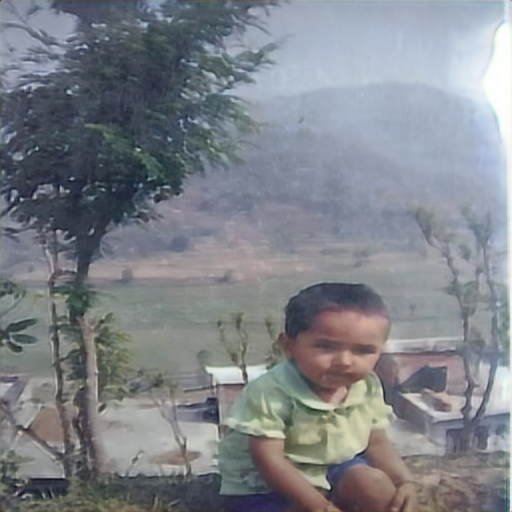

In [17]:
import requests
from io import BytesIO

response = requests.get("https://pbs.twimg.com/media/FJ8XOTbagAcpzcm?format=png&name=small")
original_image = Image.open(BytesIO(response.content))
output_image = image_manipulation.np_to_pil(
    generator(transform(original_image).unsqueeze(0).to(device)).detach().cpu().numpy()[0]
)

width, height = original_image.size
output_image.resize((width, height))
new_image = Image.new(output_image.mode, (width * 2, height))

new_image.paste(original_image, (0, 0))
new_image.paste(output_image, (width, 0))

output_image

In [20]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

In [12]:
# count the number of trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
